In [1]:
############################################## Setup and Data Preparation #######################################

import pandas as pd
import numpy as np
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.vector_ar.vecm import coint_johansen
import matplotlib.pyplot as plt

# Load your dataset
rawdata = pd.read_excel("data.xlsx", parse_dates=["t"], index_col="t")
# Load the remittances data
remittances = pd.read_excel("Remittances.xlsx", parse_dates=[0], index_col=0)

# Append the remittances data to the data and rawdata dataframes

rawdata['remittances'] = remittances.iloc[:, 0]

# Generate the variable of GDP growth

# Calculate GDP growth as the percentage change in GDP
rawdata['gdpgr'] = rawdata['realgdp'].pct_change()

# Replace the first missing value (NaN) with 0
rawdata['gdpgr'].fillna(0, inplace=True)

# Ensure variables of interest are correctly defined
variables = ['gdpgr', 'infl', 'unempl','migr','int','remittances','realgdppc']
data = rawdata[variables]

data.at[data.index[0], 'int'] = 0.4


# Add structural break dummies
rawdata['Break_2003'] = (rawdata.index.year >= 2003).astype(int)
rawdata['Break_2008'] = (rawdata.index.year >= 2008).astype(int)
rawdata['Break_2020'] = (rawdata.index.year >= 2020).astype(int)
rawdata['Break_2022'] = (rawdata.index.year >= 2022).astype(int)

data['Break_2003'] = (data.index.year >= 2003).astype(int)
data['Break_2008'] = (data.index.year >= 2008).astype(int)
data['Break_2020'] = (data.index.year >= 2020).astype(int)
data['Break_2022'] = (data.index.year >= 2022).astype(int)


# Display the first few rows to verify
data=data.head(30)
rawdata=rawdata.head(30)
data.head()
rawdata.head()



/tmp/ipykernel_2655/3399333507.py:22: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  rawdata['gdpgr'] = rawdata['realgdp'].pct_change()
/tmp/ipykernel_2655/3399333507.py:25: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  rawdata['gdpgr'].fillna(0, inplace=True)
/tmp/ipykernel_2655/3399333507.py:40: SettingWithCopyWarning: 
A value is

,realgdp,realgdppc,inv,savings,cpi,infl,impgr,expgr,unempl,popul,...,cabal,cabalpgdp,migr,int,remittances,gdpgr,Break_2003,Break_2008,Break_2020,Break_2022
t,,,,,,,,,,,,,,,,,,,,,
1994-01-01,12.559,2547.588,31.609,-1.665,38.400,7.161,0.142,-9.591,12.715,4.930,...,-0.347,-17.700,-194634.0,NaN,0.0,0.000000,0,0,0,0
1995-01-01,12.886,2717.226,31.609,12.169,38.400,7.161,0.142,-9.591,12.715,4.742,...,-0.347,-17.700,-176326.0,0.40,0.0,0.026037,0,0,0,0
1996-01-01,14.239,3113.557,31.609,-59.014,38.400,7.161,19.295,8.738,12.715,4.573,...,-0.383,-12.170,-169889.0,0.13,0.0,0.104998,0,0,0,0
1997-01-01,15.709,3562.065,29.495,-57.542,41.150,7.161,62.644,30.000,7.551,4.410,...,-0.459,-12.722,-126695.0,0.16,0.0,0.103238,0,0,0,0
1998-01-01,16.184,3772.810,43.240,-60.579,42.617,3.564,21.585,13.838,12.400,4.290,...,-0.462,-12.379,-95611.0,0.19,0.0,0.030237,0,0,0,0


In [2]:
################################## Stationarity Testing ####################################

# ADF Test Function
def adf_test(series):
    result = adfuller(series, autolag='AIC')
    return {"ADF Statistic": result[0], "p-value": result[1]}

# Test stationarity for all variables
for var in variables:
    result = adf_test(data[var].dropna())
    print(f"{var}: {result}")








gdpgr: {'ADF Statistic': np.float64(-4.717125243413058), 'p-value': np.float64(7.813528956858207e-05)}
infl: {'ADF Statistic': np.float64(-4.897151226135035), 'p-value': np.float64(3.532238457156485e-05)}
unempl: {'ADF Statistic': np.float64(-1.4331299910097108), 'p-value': np.float64(0.5662942126287479)}
migr: {'ADF Statistic': np.float64(-4.612947398619886), 'p-value': np.float64(0.0001222548927916986)}
int: {'ADF Statistic': np.float64(-1.5112081401985786), 'p-value': np.float64(0.5279597257771507)}
remittances: {'ADF Statistic': np.float64(2.4442751525558872), 'p-value': np.float64(0.9990296456801242)}
realgdppc: {'ADF Statistic': np.float64(2.626191457078332), 'p-value': np.float64(0.9990795414437587)}


In [3]:
################################ Making stationary ##############################

# Create percentage change for "unempl" and "int"
data['unemplgr'] = data['unempl'].pct_change().fillna(0)
data['intgr'] = data['int'].pct_change().fillna(0)

rawdata['unemplgr'] = rawdata['unempl'].pct_change().fillna(0)
rawdata['intgr'] = rawdata['int'].pct_change().fillna(0)

# Create first difference for "remittances"
data['remitdiff'] = data['remittances'].diff().diff().fillna(0)
rawdata['remitdiff'] = rawdata['remittances'].diff().diff().fillna(0)
data['remitdif'] = data['remittances'].diff().fillna(0)
rawdata['remitdif'] = rawdata['remittances'].diff().fillna(0)
data['realgdppcdif'] = data['realgdppc'].diff().fillna(0)
rawdata['realgdppcdif'] = rawdata['realgdppc'].diff().fillna(0)
data['realgdppcgr'] = data['realgdppc'].pct_change().fillna(0)
rawdata['realgdppcgr'] = rawdata['realgdppc'].pct_change().fillna(0)

# Create growth of remittances variable


data['remitgr'] = data['remittances'].pct_change().fillna(0)
rawdata['remitgr'] = rawdata['remittances'].pct_change().fillna(0)

# Replace infinite values with 0
data.replace([np.inf, -np.inf], 0, inplace=True)
rawdata.replace([np.inf, -np.inf], 0, inplace=True)

# Create new list of variables
statvariables = ['gdpgr', 'infl', 'migr', 'unemplgr', 'intgr', 'remitdif','remitdiff','realgdppcgr','realgdppcdif','remitgr']

# Test stationarity for the new variables
for var in statvariables:
    result = adf_test(data[var].dropna())
    print(f"{var}: {result}")



gdpgr: {'ADF Statistic': np.float64(-4.717125243413058), 'p-value': np.float64(7.813528956858207e-05)}
infl: {'ADF Statistic': np.float64(-4.897151226135035), 'p-value': np.float64(3.532238457156485e-05)}
migr: {'ADF Statistic': np.float64(-4.612947398619886), 'p-value': np.float64(0.0001222548927916986)}
unemplgr: {'ADF Statistic': np.float64(-6.6946209093364555), 'p-value': np.float64(4.028784653289028e-09)}
intgr: {'ADF Statistic': np.float64(-4.79072618646577), 'p-value': np.float64(5.6651634706277746e-05)}
remitdif: {'ADF Statistic': np.float64(-2.182900249126358), 'p-value': np.float64(0.21251011075719212)}
remitdiff: {'ADF Statistic': np.float64(-2.568008559007412), 'p-value': np.float64(0.09979113719079524)}
realgdppcgr: {'ADF Statistic': np.float64(-4.488041765009185), 'p-value': np.float64(0.0002066582645610295)}
realgdppcdif: {'ADF Statistic': np.float64(-2.9914226083907494), 'p-value': np.float64(0.03570322210370605)}
remitgr: {'ADF Statistic': np.float64(-3.910517945321793

In [4]:
############################################## Cointegration Testing #######################################

from statsmodels.tsa.stattools import coint

# Perform the cointegration test
coint_result = coint(data['realgdppcdif'], data['remitdif'])

# Extract the test statistic, p-value, and critical values
coint_statistic, p_value, critical_values = coint_result

# Print the results
print(f'Cointegration Test Statistic: {coint_statistic}')
print(f'p-value: {p_value}')
print(f'Critical Values: {critical_values}')


# Perform the cointegration test
coint_result2 = coint(data['realgdppcgr'], data['remitdif'])

# Extract the test statistic, p-value, and critical values
a,b,c = coint_result2

# Print the results
print(f'Cointegration Test Statistic: {a}')
print(f'p-value: {b}')
print(f'Critical Values: {c}')

Cointegration Test Statistic: -4.275239838872169
p-value: 0.002797555591608846
Critical Values: [-4.31395736 -3.55493606 -3.19393252]
Cointegration Test Statistic: -4.508438540233134
p-value: 0.0011861400753524127
Critical Values: [-4.31395736 -3.55493606 -3.19393252]


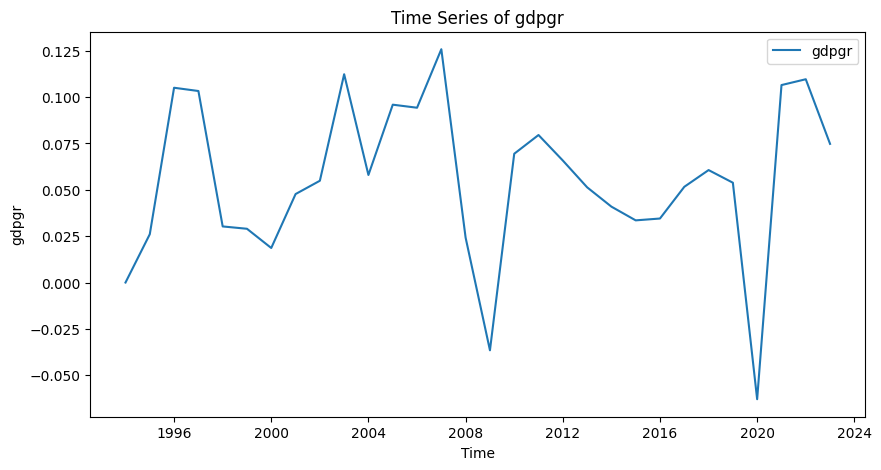

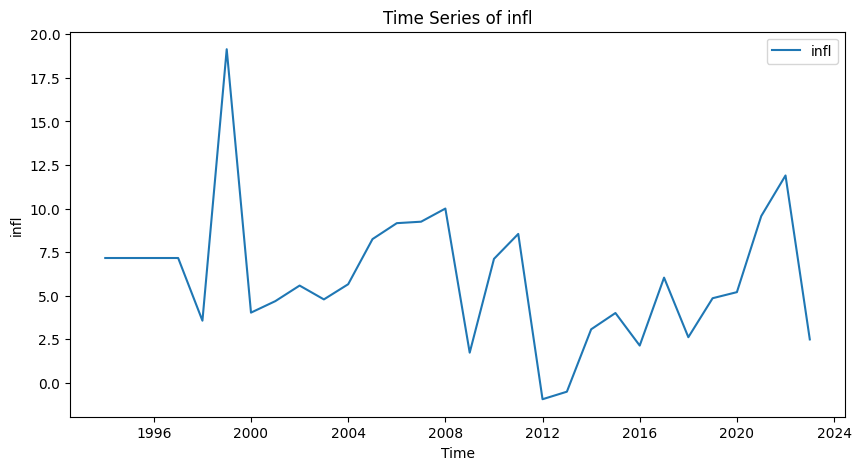

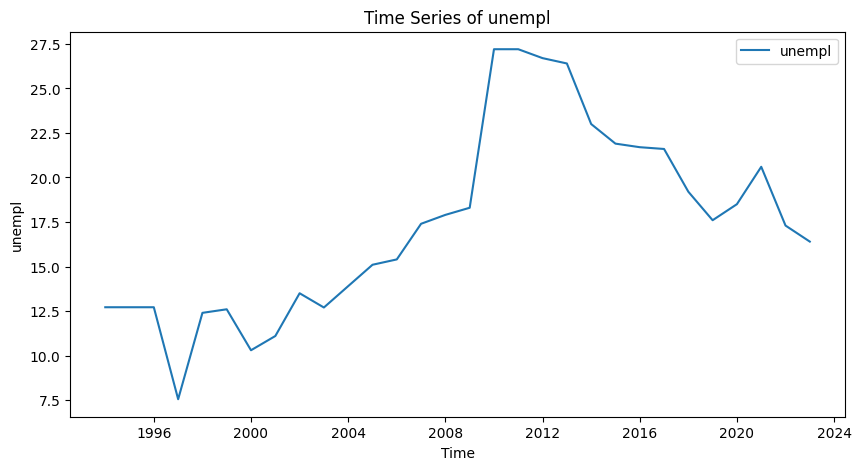

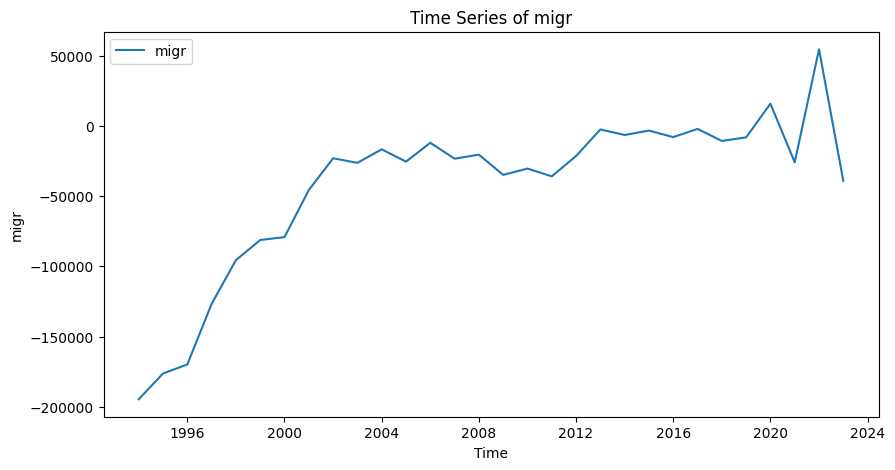

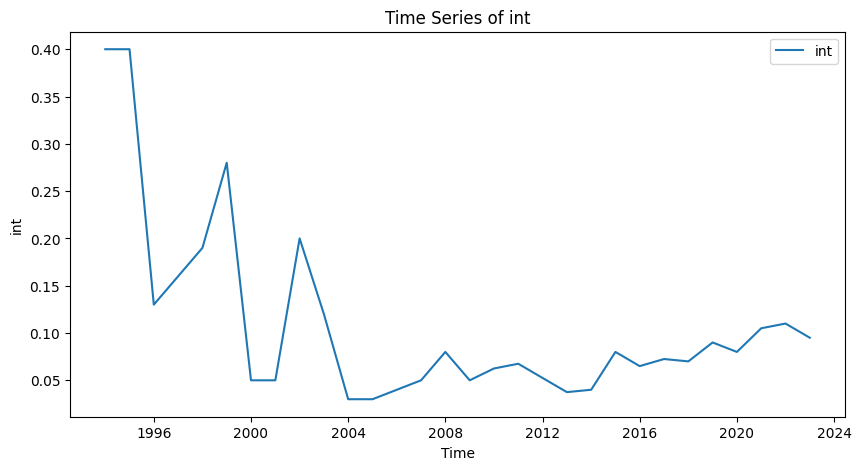

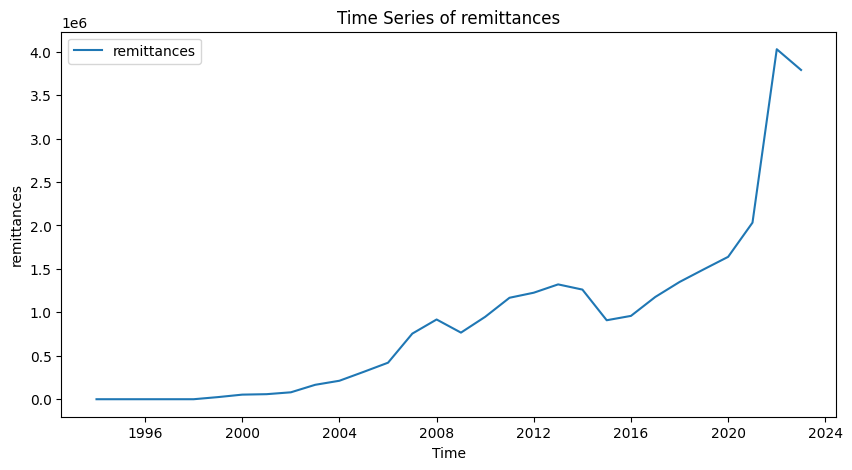

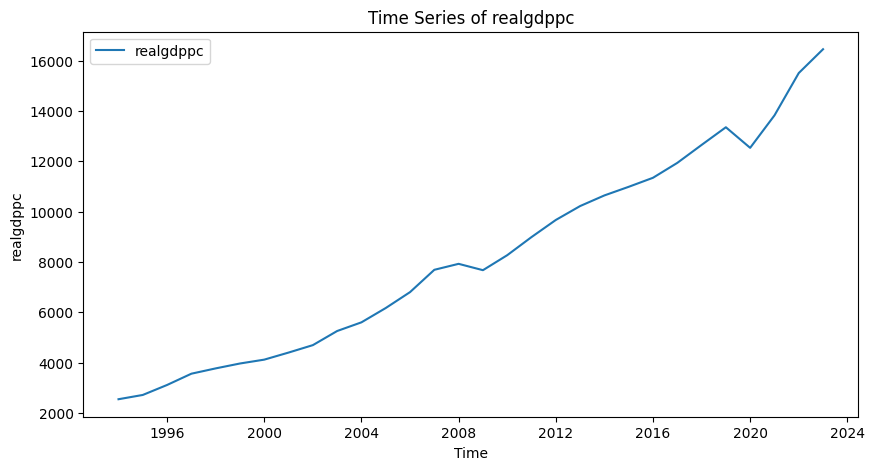

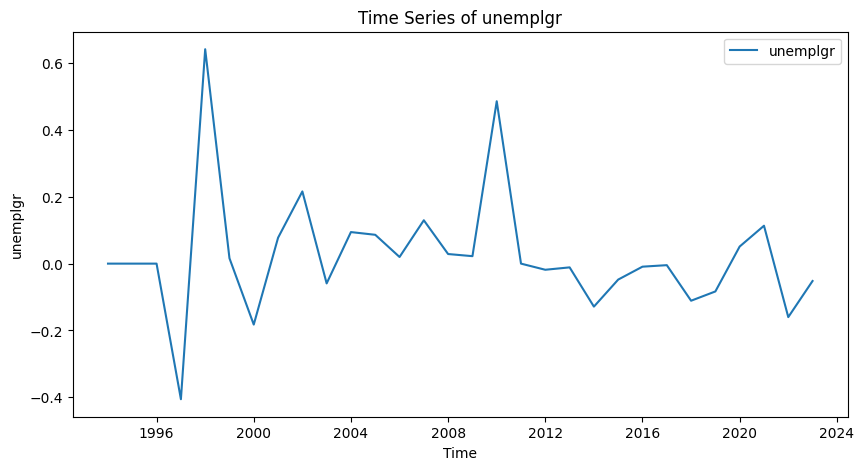

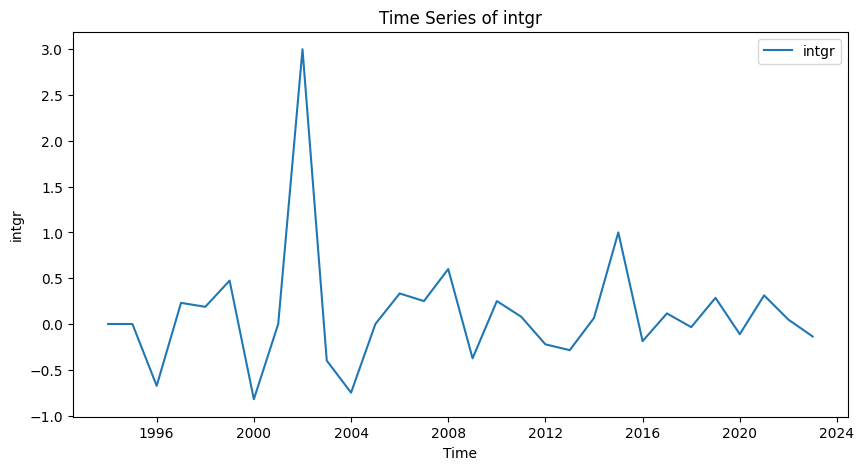

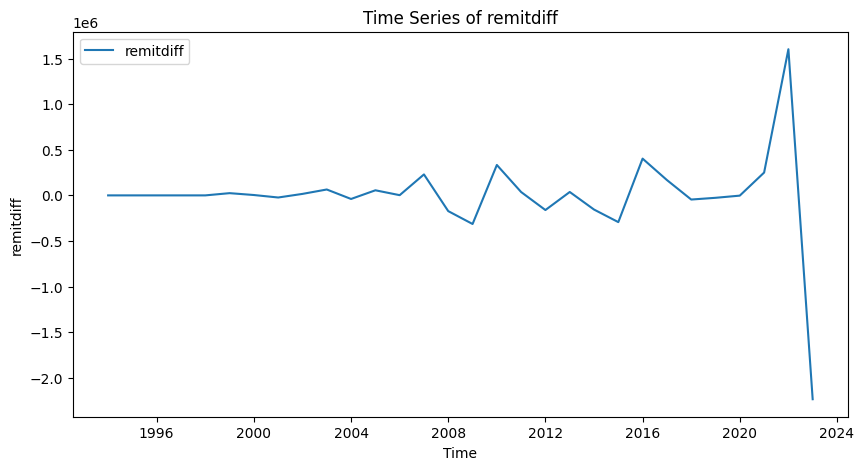

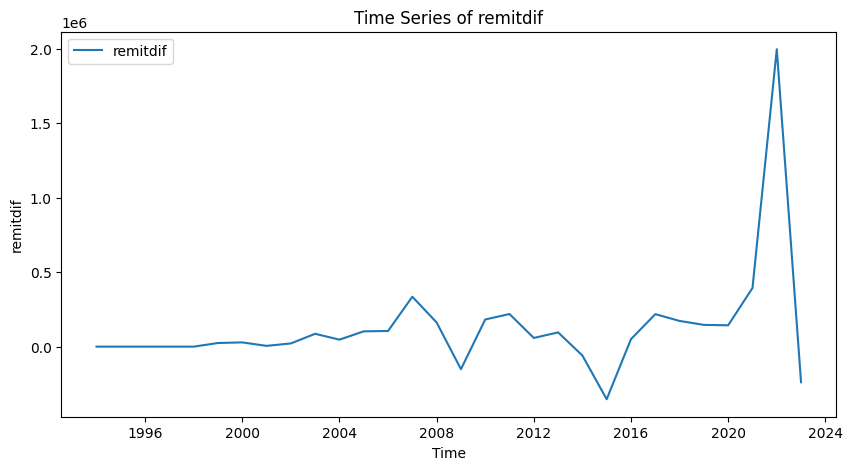

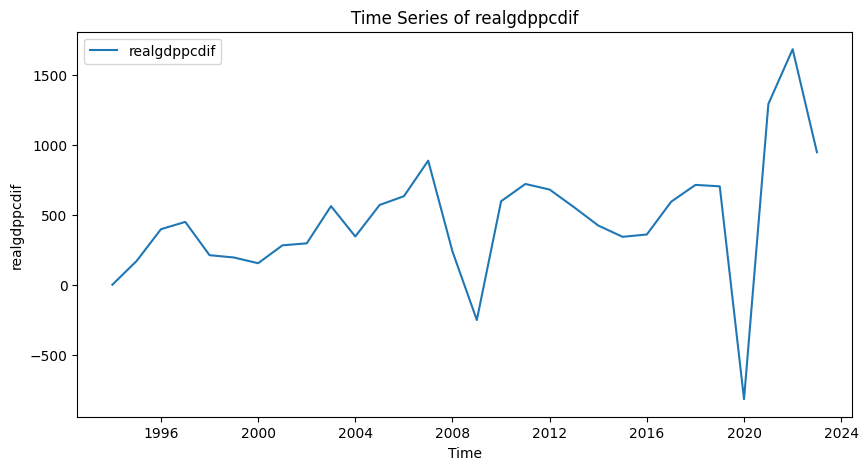

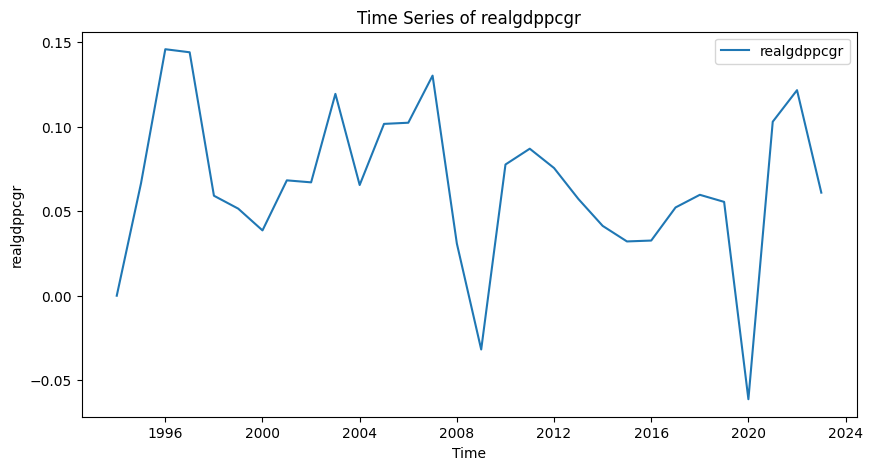

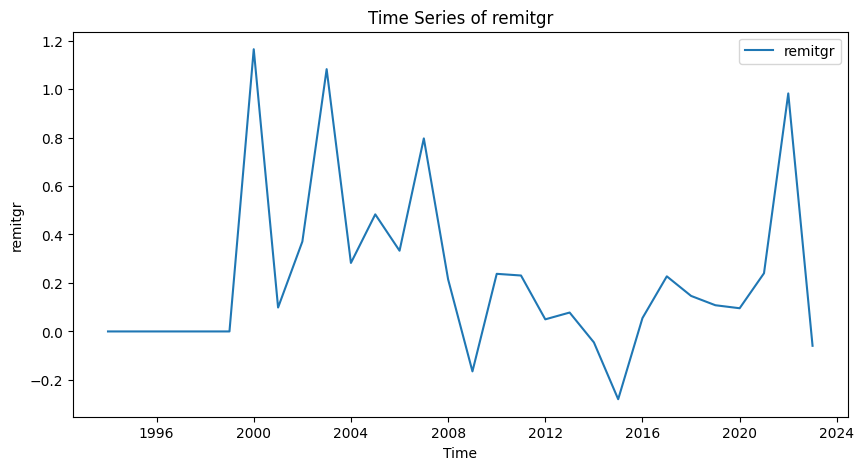

In [5]:
##################################### Plots of the key variables ######################
# Plot all variables in the data dataframe separately

# Remove break columns from the data
columns_to_plot = [col for col in data.columns if not col.startswith('Break')]

# Plot each variable in the data dataframe separately
for column in columns_to_plot:
    plt.figure(figsize=(10, 5))
    plt.plot(data.index, data[column], label=column)
    plt.title(f'Time Series of {column}')
    plt.xlabel('Time')
    plt.ylabel(column)
    plt.legend()
    plt.show()


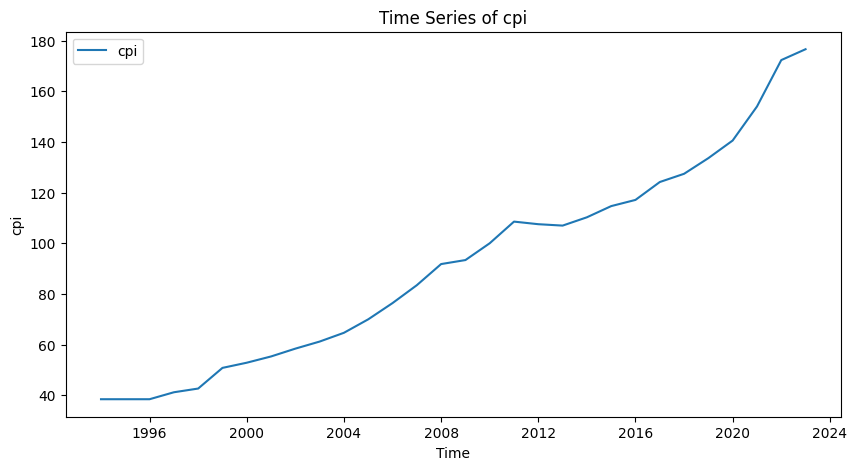

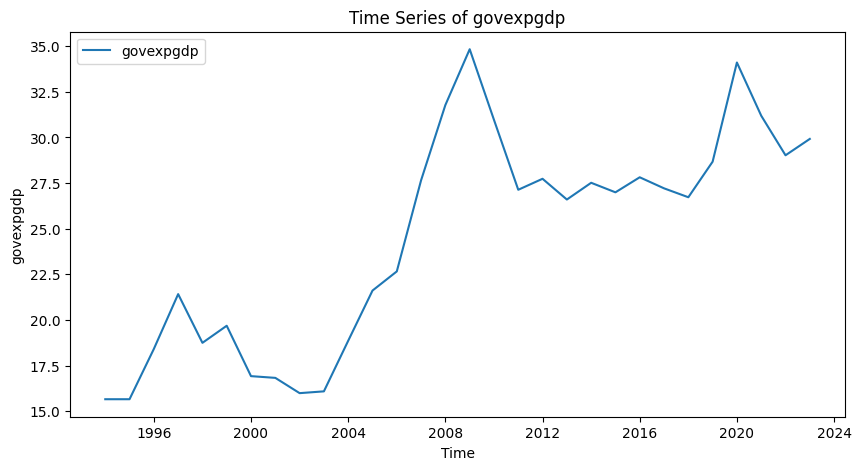

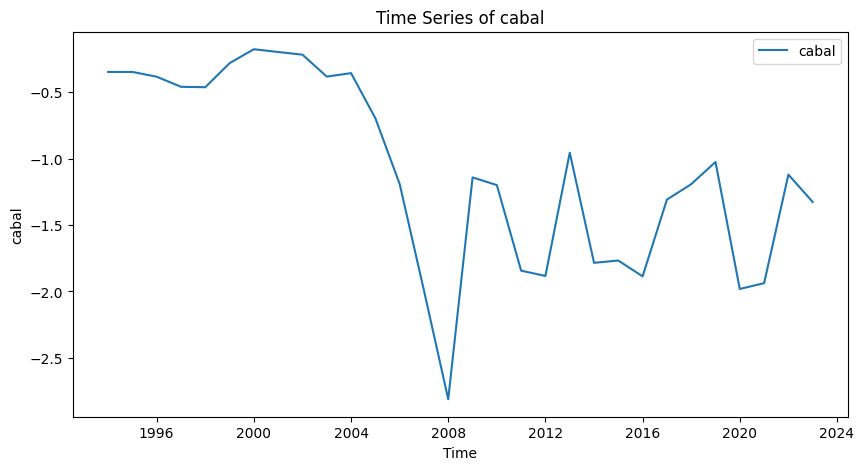

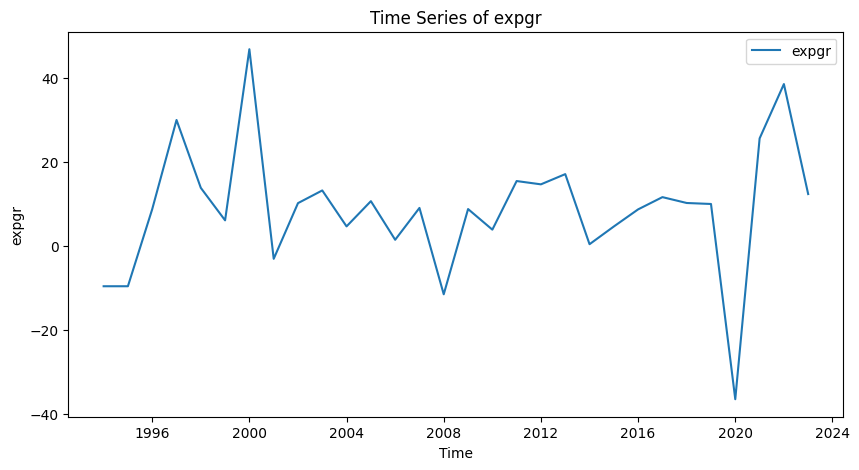

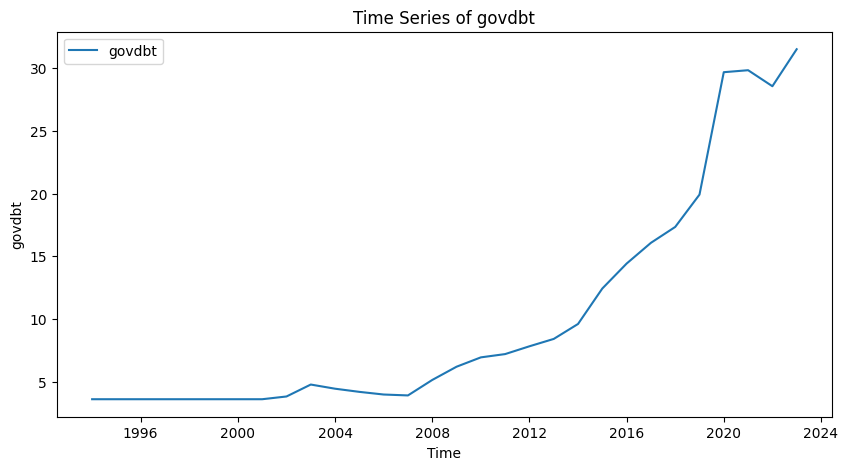

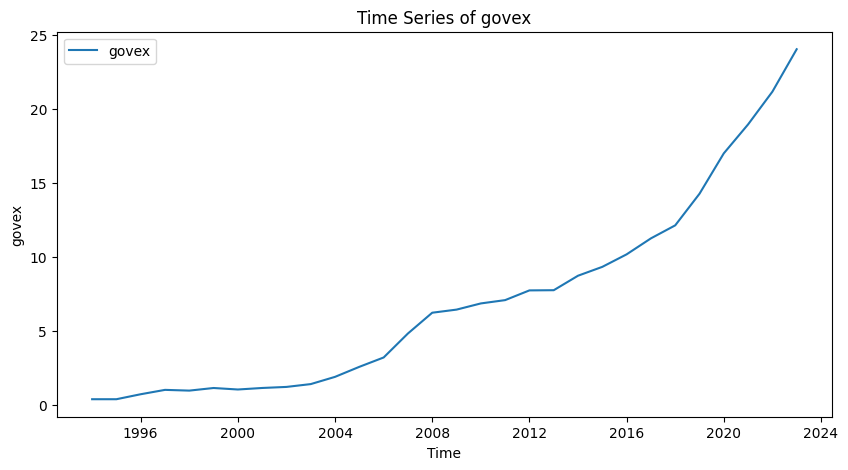

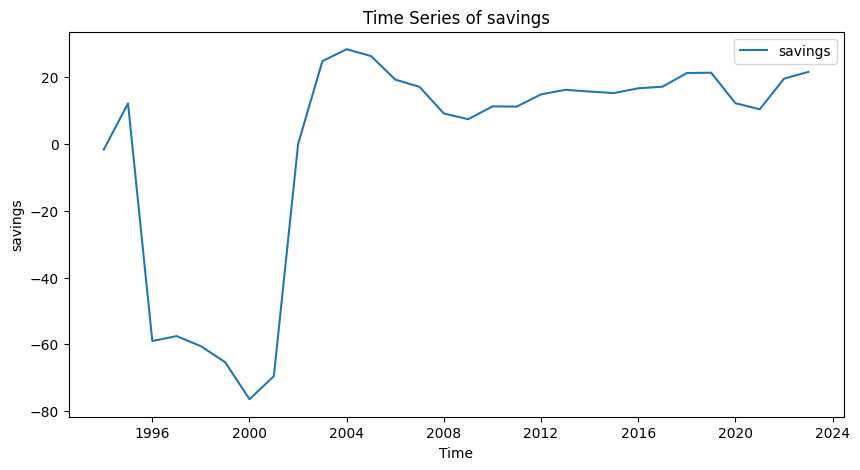

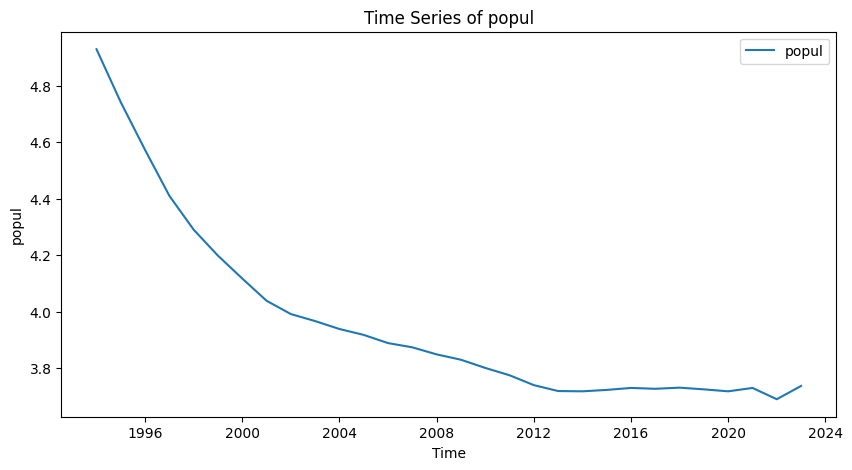

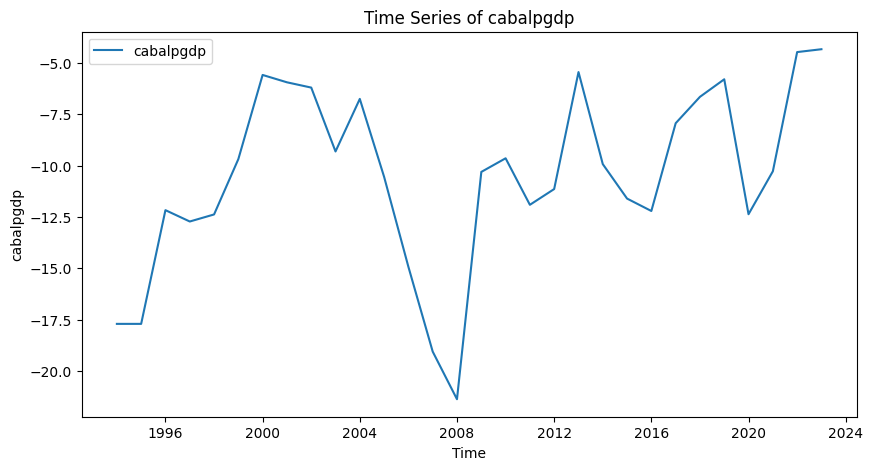

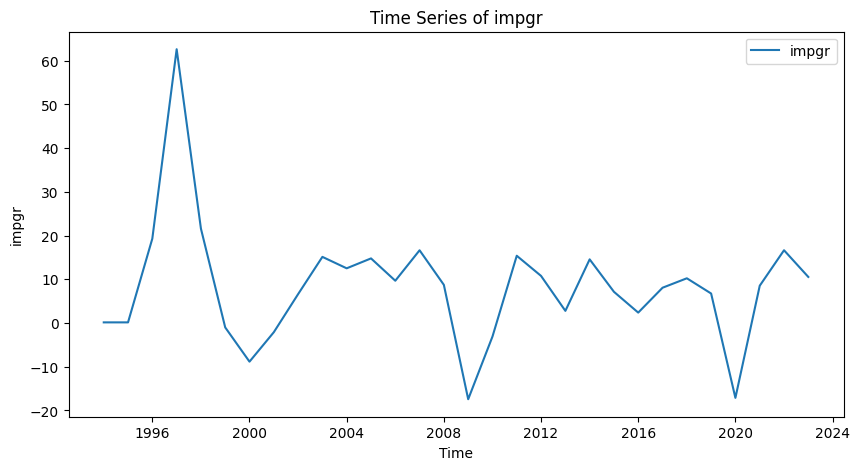

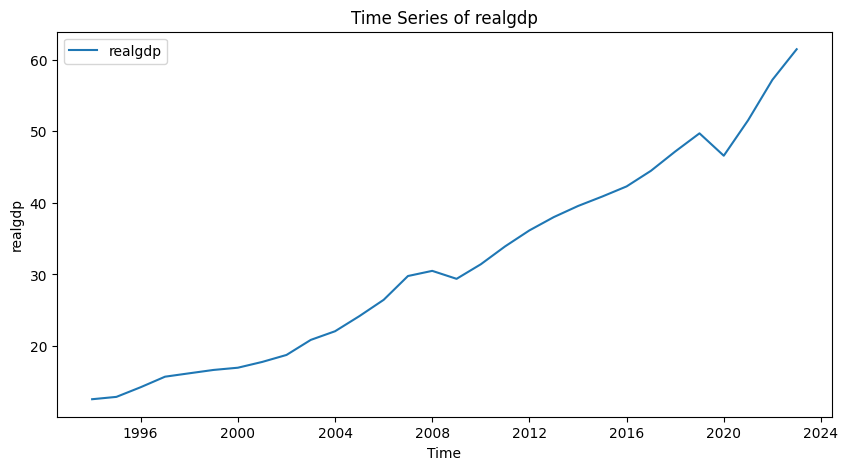

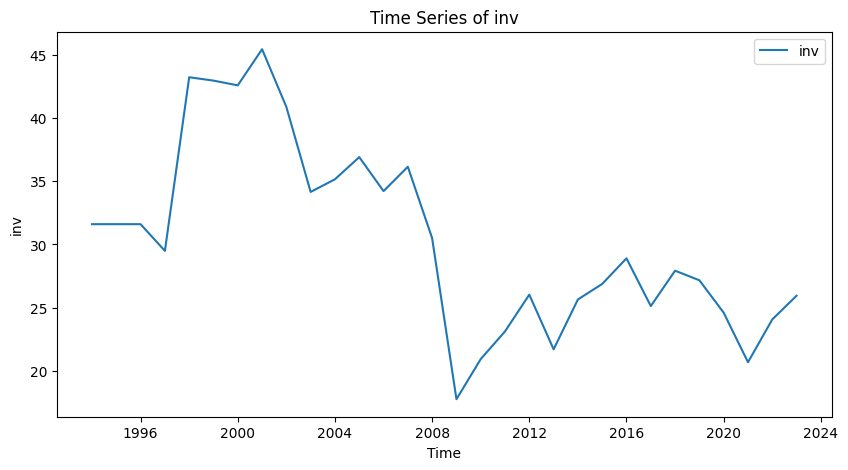

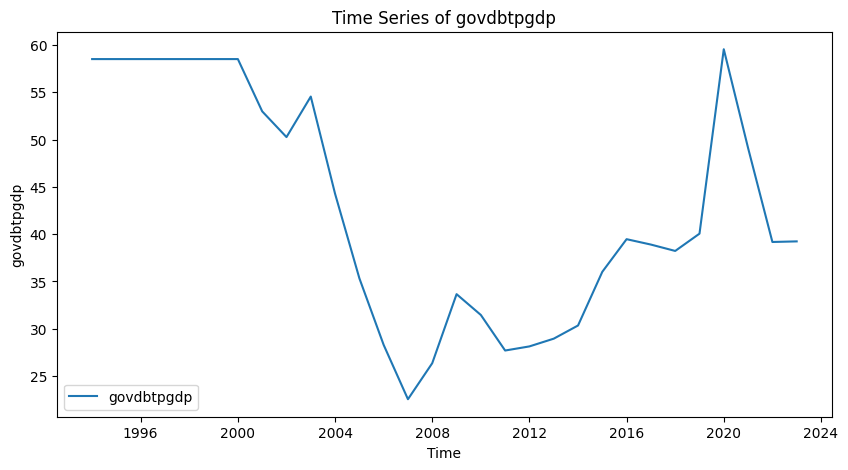

In [6]:
################################# Plot of other variables ##########################

from statsmodels.sandbox.regression.gmm import IV2SLS

rawdata=rawdata.head(30)
# Identify variables that are in rawdata but not in data
extra_vars = set(rawdata.columns) - set(data.columns)

# Plot these extra variables
for column in extra_vars:
    plt.figure(figsize=(10, 5))
    plt.plot(rawdata.index, rawdata[column], label=column)
    plt.title(f'Time Series of {column}')
    plt.xlabel('Time')
    plt.ylabel(column)
    plt.legend()
    plt.show()

In [7]:
################################### OLS with growth data ######################################

import statsmodels.api as sm

# Define the dependent variable
y = data['realgdppcgr']

# Define the independent variables
X = data[['int', 'migr', 'Break_2003', 'Break_2008', 'Break_2020', 'Break_2022', 'remitdif']]


# Drop rows with NaN values (due to lagging)
X = X.dropna()
y = y.loc[X.index]

# Add a constant to the independent variables
X = sm.add_constant(X)

# Fit the OLS model with robust covariance type
model = sm.OLS(y, X).fit()

# Print the summary of the regression
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:            realgdppcgr   R-squared:                       0.467
Model:                            OLS   Adj. R-squared:                  0.298
Method:                 Least Squares   F-statistic:                     2.758
Date:                Sun, 15 Dec 2024   Prob (F-statistic):             0.0323
Time:                        16:55:19   Log-Likelihood:                 59.409
No. Observations:                  30   AIC:                            -102.8
Df Residuals:                      22   BIC:                            -91.61
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0658      0.029      2.291      0.0

In [8]:
################################### OLS with level data ######################################

import statsmodels.api as sm

# Define the dependent variable
y2 = rawdata['realgdppc']


rawdata['realgdppc_lag'] = rawdata['realgdppc'].shift(1)

# Define the independent variables
X2 = rawdata[['int', 'unempl', 'migr', 'Break_2003', 'Break_2008', 'Break_2020', 'Break_2022','realgdppc_lag']]

# Add trend variable
rawdata['trend'] = np.arange(len(rawdata))

# Include trend in the independent variables
X2['trend'] = rawdata['trend']

# Drop rows with NaN values (due to lagging)
X2 = X2.dropna()
y2 = y2.loc[X2.index]

# Add a constant to the independent variables

X2 = sm.add_constant(X2)

# Fit the OLS model with robust covariance type
model2 = sm.OLS(y2, X2).fit()

# Print the summary of the regression
print(model2.summary())


                            OLS Regression Results                            
Dep. Variable:              realgdppc   R-squared:                       0.997
Model:                            OLS   Adj. R-squared:                  0.996
Method:                 Least Squares   F-statistic:                     711.2
Date:                Sun, 15 Dec 2024   Prob (F-statistic):           4.44e-22
Time:                        16:55:19   Log-Likelihood:                -196.55
No. Observations:                  29   AIC:                             413.1
Df Residuals:                      19   BIC:                             426.8
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const           214.2596    440.358      0.487

/tmp/ipykernel_2655/2207890817.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X2['trend'] = rawdata['trend']


In [9]:
############################### OLS with log GDP ######################################

# Generate the log of realgdppc
rawdata['log_realgdppc'] = np.log(rawdata['realgdppc'])

# Define the dependent variable
y3 = rawdata['log_realgdppc']

# Define the independent variables
X3 = rawdata[['int', 'unempl', 'migr', 'Break_2003', 'Break_2008', 'Break_2020', 'Break_2022']]

# Add lagged variables
X3['log_realgdppc_lag'] = rawdata['log_realgdppc'].shift(1)

# Add trend variable
X3['trend'] = rawdata['trend']

# Drop rows with NaN values (due to lagging)
X3 = X3.dropna()
y3 = y3.loc[X3.index]

# Add a constant to the independent variables
X3 = sm.add_constant(X3)

# Fit the OLS model with robust covariance type
model3 = sm.OLS(y3, X3).fit()

# Print the summary of the regression
print(model3.summary())

                            OLS Regression Results                            
Dep. Variable:          log_realgdppc   R-squared:                       0.997
Model:                            OLS   Adj. R-squared:                  0.996
Method:                 Least Squares   F-statistic:                     813.4
Date:                Sun, 15 Dec 2024   Prob (F-statistic):           1.24e-22
Time:                        16:55:19   Log-Likelihood:                 64.624
No. Observations:                  29   AIC:                            -109.2
Df Residuals:                      19   BIC:                            -95.57
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 3.3685      1.19

/tmp/ipykernel_2655/2349127147.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X3['log_realgdppc_lag'] = rawdata['log_realgdppc'].shift(1)
/tmp/ipykernel_2655/2349127147.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X3['trend'] = rawdata['trend']


In [10]:
#################################### OLS with several lags  of log GDP pc (this looks ok)##############################


from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.api import VAR

# Determine the optimal number of lags using AIC

# Prepare the data for VAR model
model_data = rawdata[['log_realgdppc', 'Break_2003', 'Break_2008', 'Break_2020', 'Break_2022','trend']].dropna()

# Fit the VAR model
model = VAR(model_data)
lag_order = model.select_order(maxlags=1)
optimal_lags = lag_order.aic
print(f'Optimal number of lags based on AIC: {optimal_lags}')

# Add the optimal number of lags to the independent variables
for i in range(1, optimal_lags + 1):
    model_data[f'log_realgdppc_lag{i}'] = model_data['log_realgdppc'].shift(i)

# Drop rows with NaN values (due to lagging)
model_data = model_data.dropna()

# Define the dependent variable
y4 = model_data['log_realgdppc']

# Define the independent variables
X4 = model_data.drop(columns=['log_realgdppc'])

# Add a constant to the independent variables
X4 = sm.add_constant(X4)

# Fit the OLS model with robust covariance type
model4 = sm.OLS(y4, X4).fit()

# Print the summary of the regression
print(model4.summary())

Optimal number of lags based on AIC: 1
                            OLS Regression Results                            
Dep. Variable:          log_realgdppc   R-squared:                       0.997
Model:                            OLS   Adj. R-squared:                  0.996
Method:                 Least Squares   F-statistic:                     1118.
Date:                Sun, 15 Dec 2024   Prob (F-statistic):           3.54e-26
Time:                        16:55:19   Log-Likelihood:                 61.238
No. Observations:                  29   AIC:                            -108.5
Df Residuals:                      22   BIC:                            -98.91
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------

/usr/local/python/3.12.1/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)


In [11]:
################################### OLS with several lags of realgdp (this looks ok) ######################################

# Define the dependent variable
y5 = rawdata['realgdp']

# Define the independent variables
X5 = rawdata[['int','Break_2003', 'Break_2008', 'Break_2020', 'Break_2022']]

# Add lagged variables
X5['realgdp_lag'] = rawdata['realgdp'].shift(1)

X5['migr_lag'] = rawdata['migr'].shift(1)

# Add trend variable
X5['trend'] = rawdata['trend']

# Drop rows with NaN values (due to lagging)
X5 = X5.dropna()
y5 = y5.loc[X5.index]

# Add a constant to the independent variables
X5 = sm.add_constant(X5)

# Fit the OLS model with robust covariance type
model5 = sm.OLS(y5, X5).fit()

# Print the summary of the regression
print(model5.summary())

                            OLS Regression Results                            
Dep. Variable:                realgdp   R-squared:                       0.995
Model:                            OLS   Adj. R-squared:                  0.993
Method:                 Least Squares   F-statistic:                     477.6
Date:                Sun, 15 Dec 2024   Prob (F-statistic):           4.13e-21
Time:                        16:55:19   Log-Likelihood:                -40.878
No. Observations:                  29   AIC:                             99.76
Df Residuals:                      20   BIC:                             112.1
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.9291      1.757      0.529      

/tmp/ipykernel_2655/3872530948.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X5['realgdp_lag'] = rawdata['realgdp'].shift(1)
/tmp/ipykernel_2655/3872530948.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X5['migr_lag'] = rawdata['migr'].shift(1)
/tmp/ipykernel_2655/3872530948.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pan

In [12]:
################################## OLS with log real gdp with several lags (this looks ok)#################################

# Generate the log of realgdp
rawdata['log_realgdp'] = np.log(rawdata['realgdp'])

# Define the dependent variable
y6 = rawdata['log_realgdp']

# Define the independent variables

X6 = rawdata[['int', 'Break_2003', 'Break_2008', 'Break_2020', 'Break_2022']]

# Add lagged variables

X6['log_realgdp_lag'] = rawdata['log_realgdp'].shift(1)

X6['migr_lag'] = rawdata['migr'].shift(1)

# Add trend variable

X6['trend'] = rawdata['trend']

# Drop rows with NaN values (due to lagging)

X6 = X6.dropna()

y6 = y6.loc[X6.index]

# Add a constant to the independent variables

X6 = sm.add_constant(X6)

# Fit the OLS model with robust covariance type

model6 = sm.OLS(y6, X6).fit()

# Print the summary of the regression

print(model6.summary())


                            OLS Regression Results                            
Dep. Variable:            log_realgdp   R-squared:                       0.996
Model:                            OLS   Adj. R-squared:                  0.995
Method:                 Least Squares   F-statistic:                     692.5
Date:                Sun, 15 Dec 2024   Prob (F-statistic):           1.03e-22
Time:                        16:55:19   Log-Likelihood:                 63.451
No. Observations:                  29   AIC:                            -108.9
Df Residuals:                      20   BIC:                            -96.60
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               1.1999      0.442     

/tmp/ipykernel_2655/896042900.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X6['log_realgdp_lag'] = rawdata['log_realgdp'].shift(1)
/tmp/ipykernel_2655/896042900.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X6['migr_lag'] = rawdata['migr'].shift(1)
/tmp/ipykernel_2655/896042900.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.or

In [13]:
###################################### OLS with cross product of dummy and trend (This looks ok)###############################

# Create interaction terms between structural break variables and trend
rawdata['Break_2003_trend'] = rawdata['Break_2003'] * rawdata['trend']
rawdata['Break_2008_trend'] = rawdata['Break_2008'] * rawdata['trend']
rawdata['Break_2020_trend'] = rawdata['Break_2020'] * rawdata['trend']
rawdata['Break_2022_trend'] = rawdata['Break_2022'] * rawdata['trend']

# Define the dependent variable
y7 = rawdata['log_realgdp']

# Add lagged log real GDP variable
rawdata['log_realgdp_lag'] = rawdata['log_realgdp'].shift(1)

# Drop rows with NaN values (due to lagging)
rawdata = rawdata.dropna()

# Update the dependent variable to match the index of the independent variables
y7 = rawdata['log_realgdp']

# Define the independent variables
X7 = rawdata[['Break_2003', 'Break_2008', 'Break_2020', 'Break_2022', 'Break_2003_trend', 'Break_2008_trend', 'Break_2020_trend', 'Break_2022_trend','log_realgdp_lag']]

# Add a constant to the independent variables
X7 = sm.add_constant(X7)

# Fit the OLS model with robust covariance type
model7 = sm.OLS(y7, X7).fit()

# Print the summary of the regression
print(model7.summary())

                            OLS Regression Results                            
Dep. Variable:            log_realgdp   R-squared:                       0.997
Model:                            OLS   Adj. R-squared:                  0.996
Method:                 Least Squares   F-statistic:                     818.8
Date:                Sun, 15 Dec 2024   Prob (F-statistic):           1.17e-22
Time:                        16:55:19   Log-Likelihood:                 68.317
No. Observations:                  29   AIC:                            -116.6
Df Residuals:                      19   BIC:                            -103.0
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const                0.4306      0.218  

In [14]:
##############################  RR paper OLS #####################################

# Define the dependent variable
y_rr = rawdata['log_realgdp']

# Define the independent variables
X_rr = rawdata[['log_realgdp_lag', 'int', 'trend', 'Break_2022']]

# Add additional lags
X_rr['log_realgdp_lag2'] = rawdata['log_realgdp'].shift(2)
X_rr['int_lag1'] = rawdata['int'].shift(1)
X_rr['int_lag2'] = rawdata['int'].shift(2)

# Drop rows with NaN values (due to lagging)
X_rr = X_rr.dropna()
y_rr = y_rr.loc[X_rr.index]

# Add a constant to the independent variables
X_rr = sm.add_constant(X_rr)

# Fit the OLS model with robust covariance type
model_rr = sm.OLS(y_rr, X_rr).fit()

# Print the summary of the regression
print(model_rr.summary())

                            OLS Regression Results                            
Dep. Variable:            log_realgdp   R-squared:                       0.994
Model:                            OLS   Adj. R-squared:                  0.992
Method:                 Least Squares   F-statistic:                     462.8
Date:                Sun, 15 Dec 2024   Prob (F-statistic):           7.47e-20
Time:                        16:55:19   Log-Likelihood:                 54.837
No. Observations:                  27   AIC:                            -93.67
Df Residuals:                      19   BIC:                            -83.31
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const                1.4113      0.490  

/tmp/ipykernel_2655/1277735175.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_rr['log_realgdp_lag2'] = rawdata['log_realgdp'].shift(2)
/tmp/ipykernel_2655/1277735175.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_rr['int_lag1'] = rawdata['int'].shift(1)
/tmp/ipykernel_2655/1277735175.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.py

In [15]:
###################################### detrended variables (this is not bad) ######################################


from statsmodels.tsa.tsatools import detrend


# Detrend the variables
rawdata['detrended_realgdp'] = detrend(rawdata['realgdp'])
rawdata['detrended_int'] = detrend(rawdata['int'])
rawdata['detrended_migr'] = detrend(rawdata['migr'])

# Add lagged detrended real GDP
rawdata['detrended_realgdp_lag'] = rawdata['detrended_realgdp'].shift(1)

# Drop rows with NaN values (due to lagging)
rawdata = rawdata.dropna()

# Define the dependent variable
y_detrended = rawdata['detrended_realgdp']

# Define the independent variables
X_detrended = rawdata[['detrended_realgdp_lag', 'detrended_int', 'detrended_migr', 'Break_2022', 'Break_2003', 'Break_2008', 'Break_2020']]

# Add a constant to the independent variables
X_detrended = sm.add_constant(X_detrended)

# Fit the OLS model with robust covariance type
model_detrended = sm.OLS(y_detrended, X_detrended).fit()

# Print the summary of the regression
print(model_detrended.summary())

                            OLS Regression Results                            
Dep. Variable:      detrended_realgdp   R-squared:                       0.864
Model:                            OLS   Adj. R-squared:                  0.816
Method:                 Least Squares   F-statistic:                     18.14
Date:                Sun, 15 Dec 2024   Prob (F-statistic):           2.22e-07
Time:                        16:55:19   Log-Likelihood:                -33.592
No. Observations:                  28   AIC:                             83.18
Df Residuals:                      20   BIC:                             93.84
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                     0.06

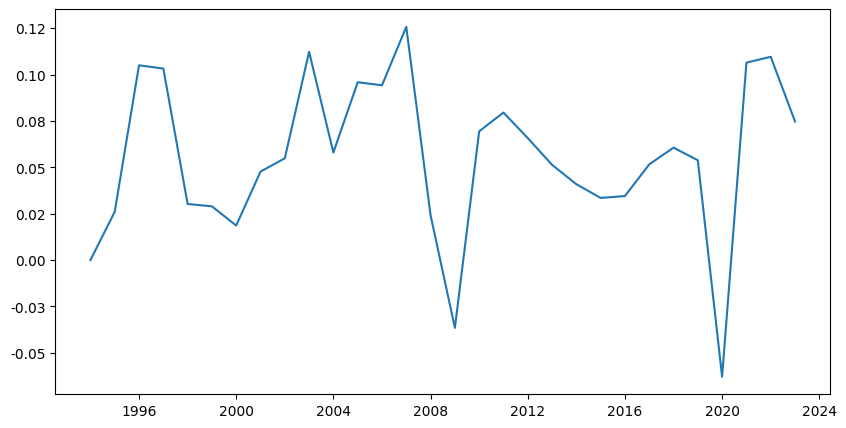

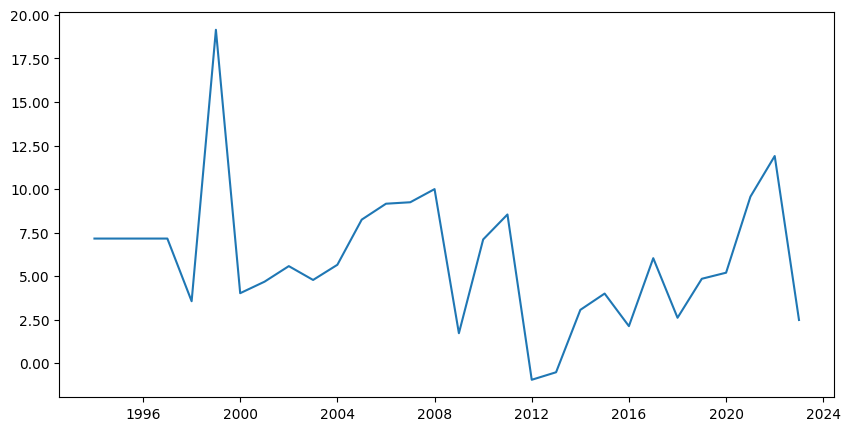

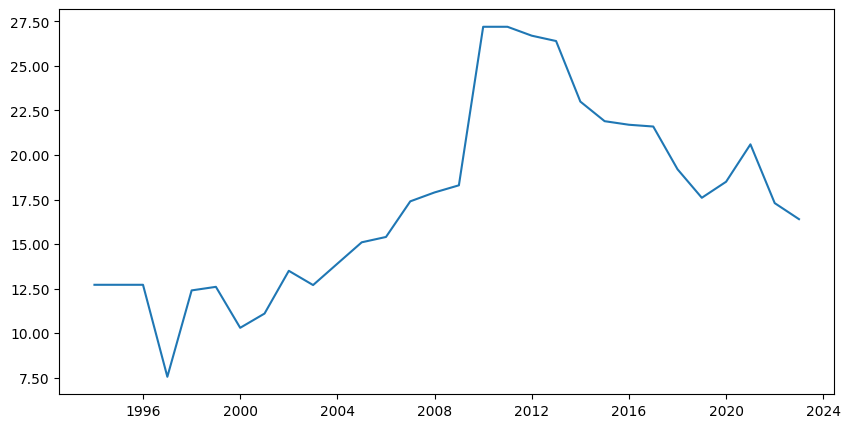

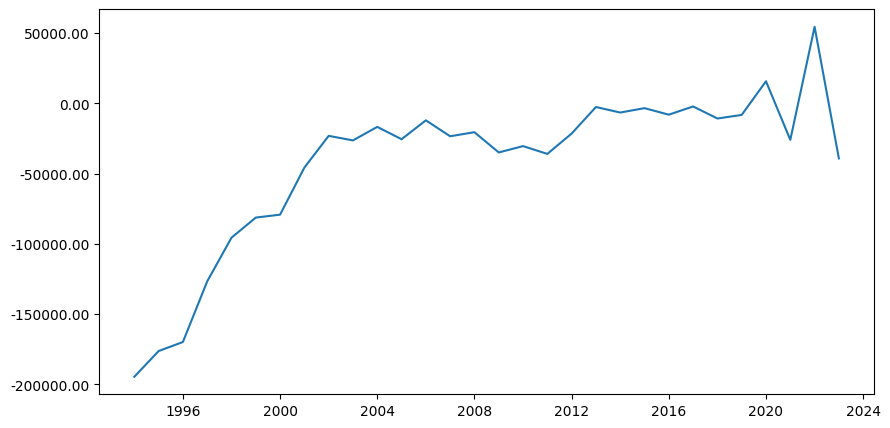

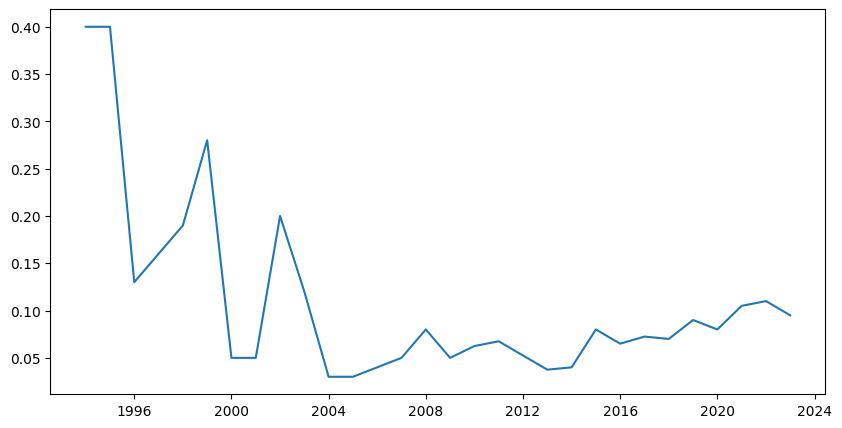

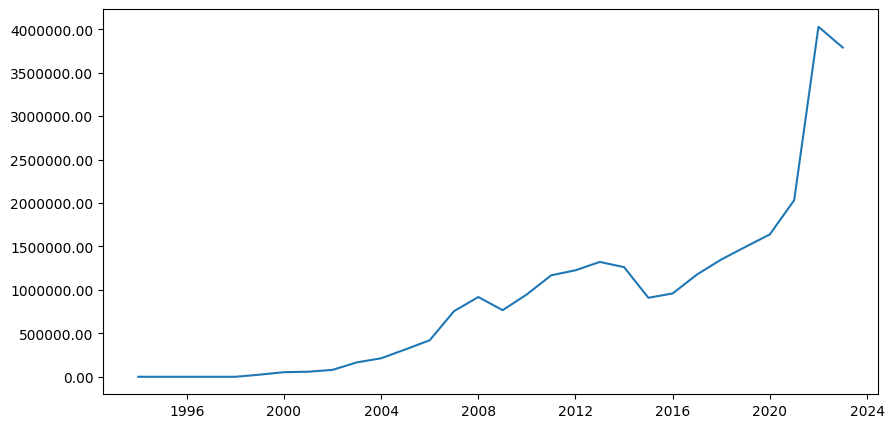

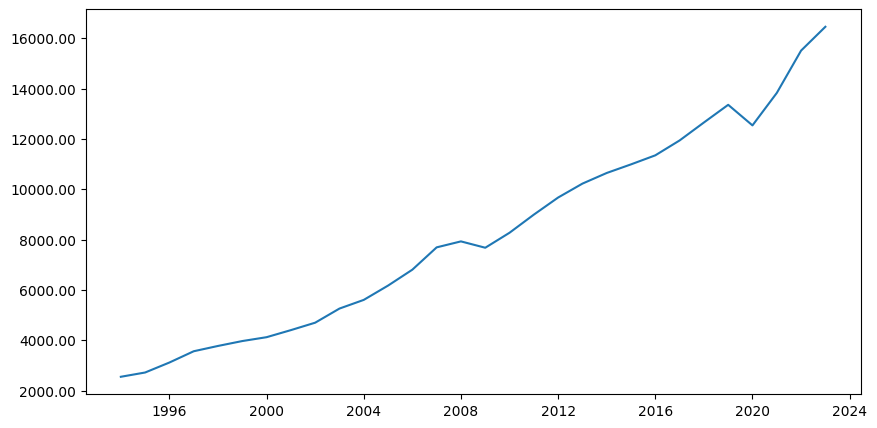

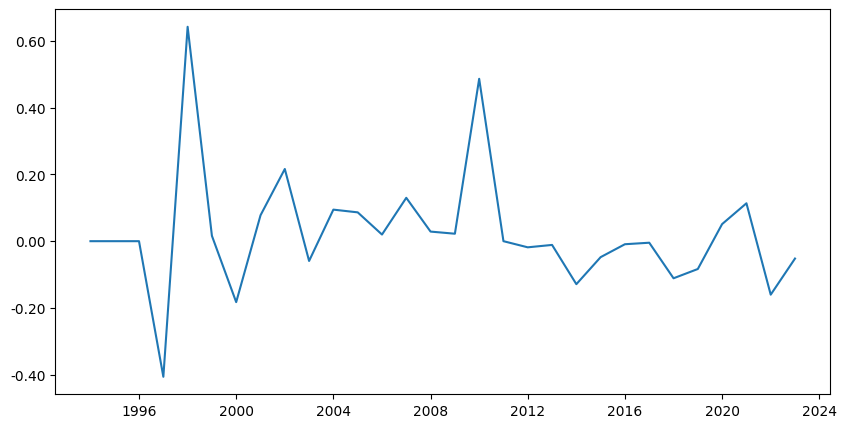

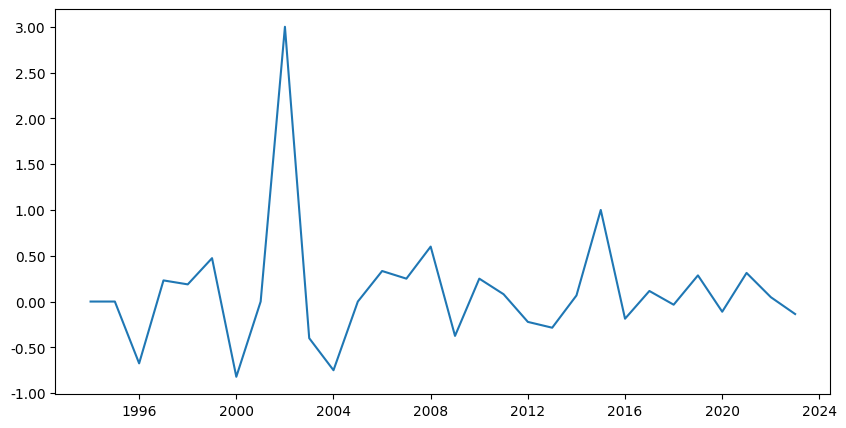

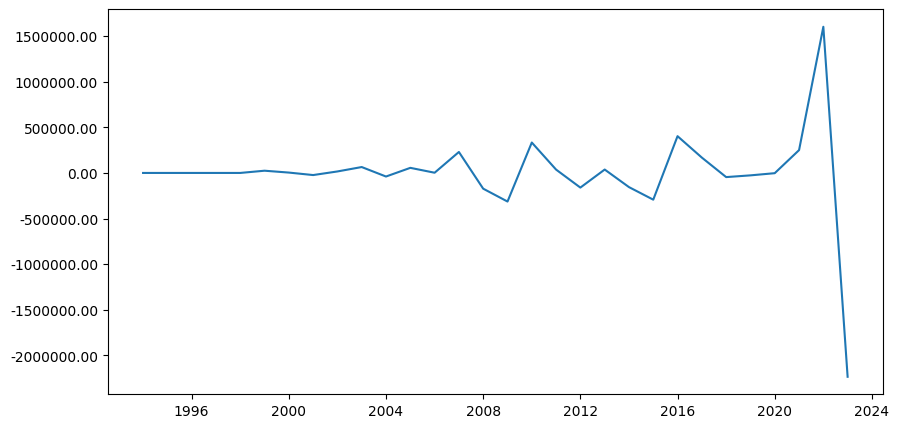

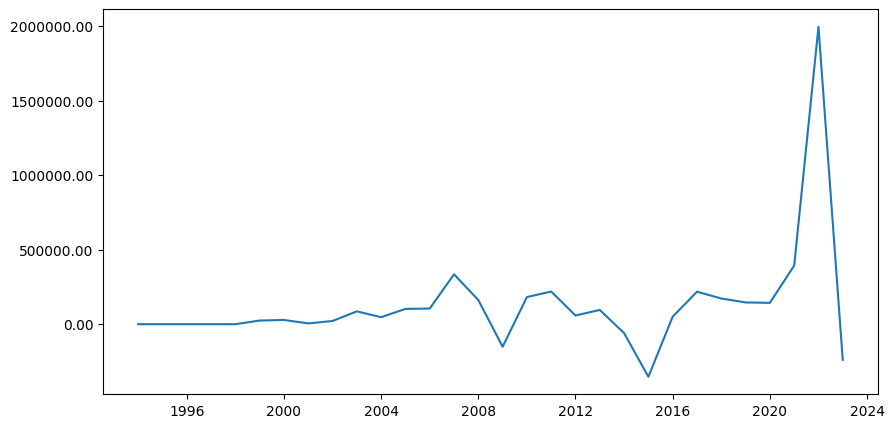

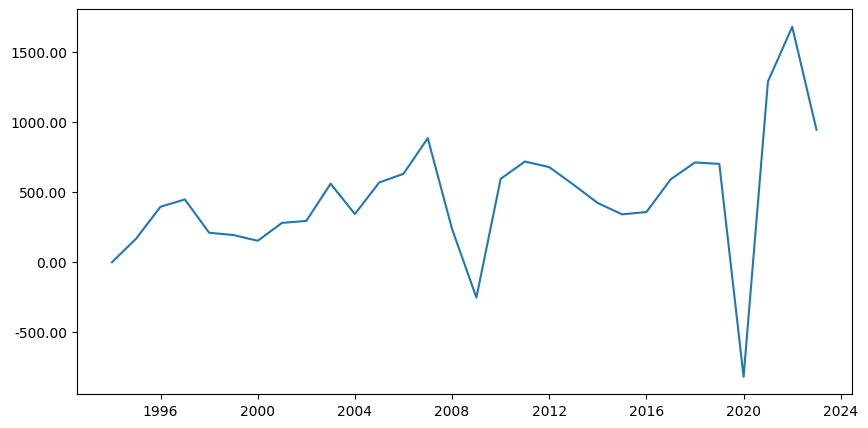

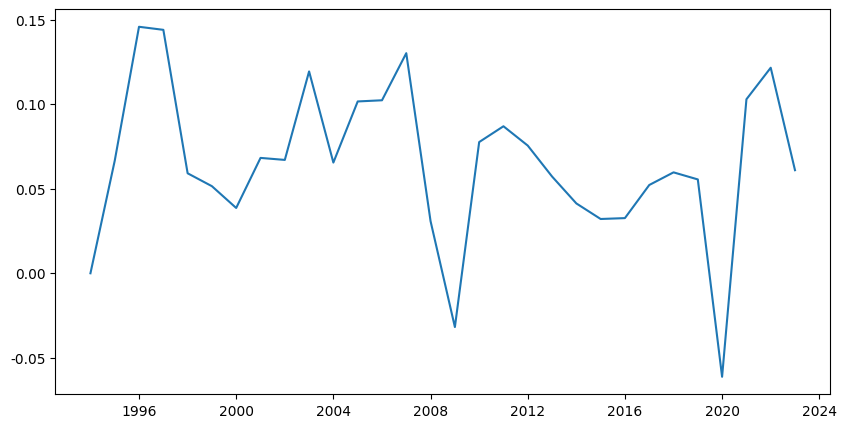

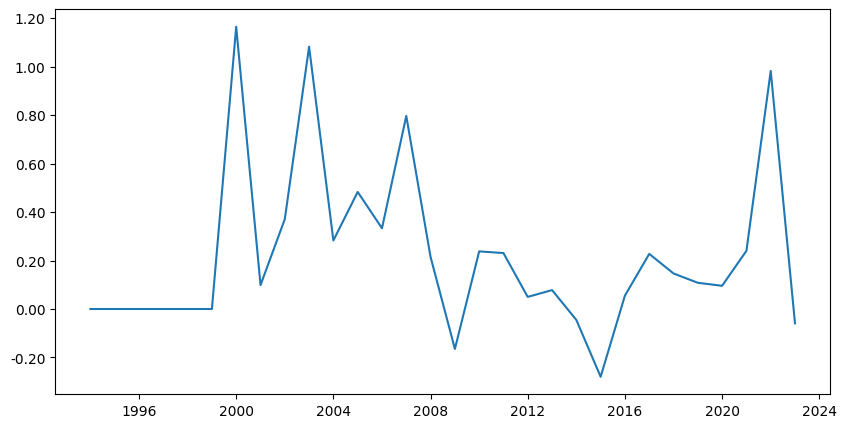

In [16]:
##################################### Plots of the key variables for slides ######################
# Plot all variables in the data dataframe separately

# Remove break columns from the data
columns_to_plot = [col for col in data.columns if not col.startswith('Break')]

# Plot each variable in the data dataframe separately
for column in columns_to_plot:
    plt.figure(figsize=(10, 5))
    plt.plot(data.index, data[column], label=column)
    plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.2f}'))
    plt.show()



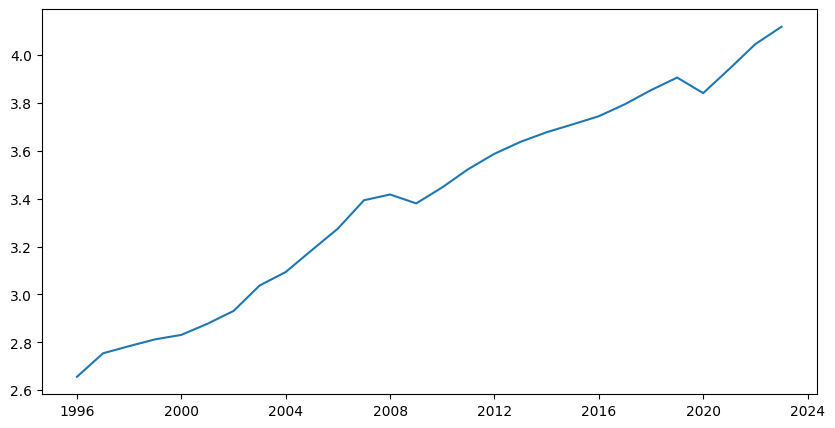

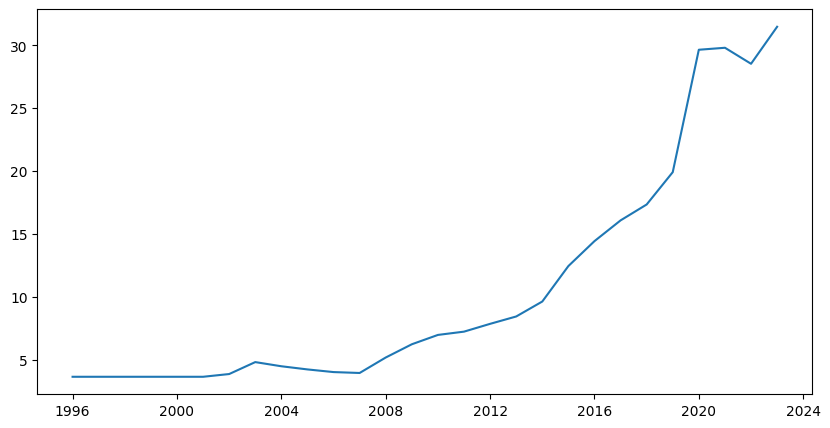

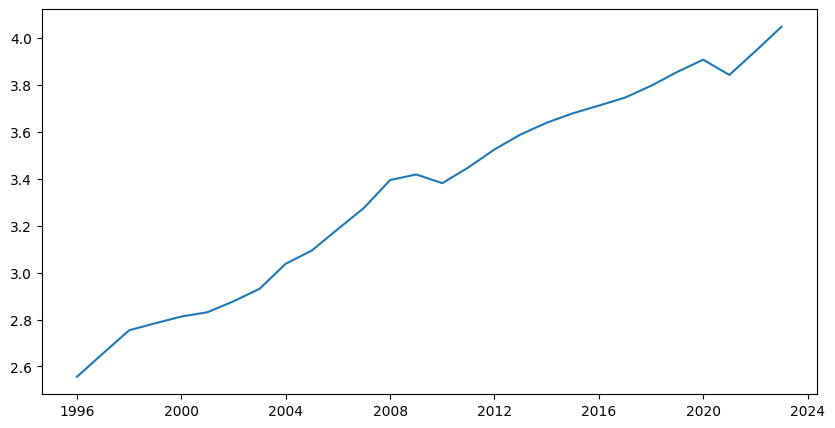

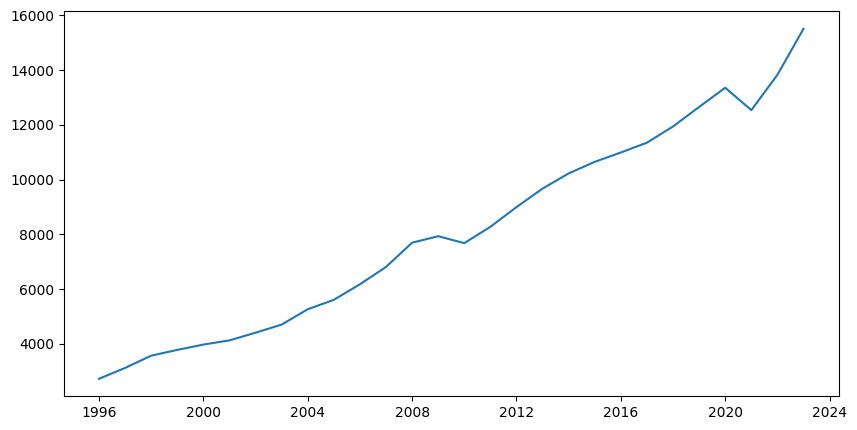

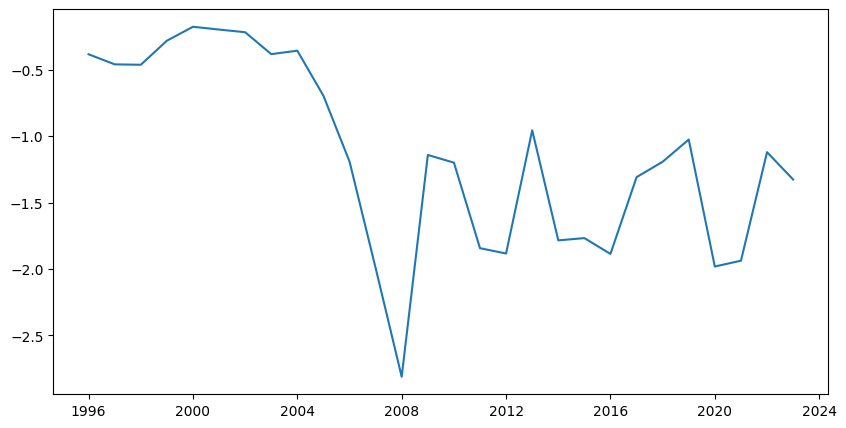

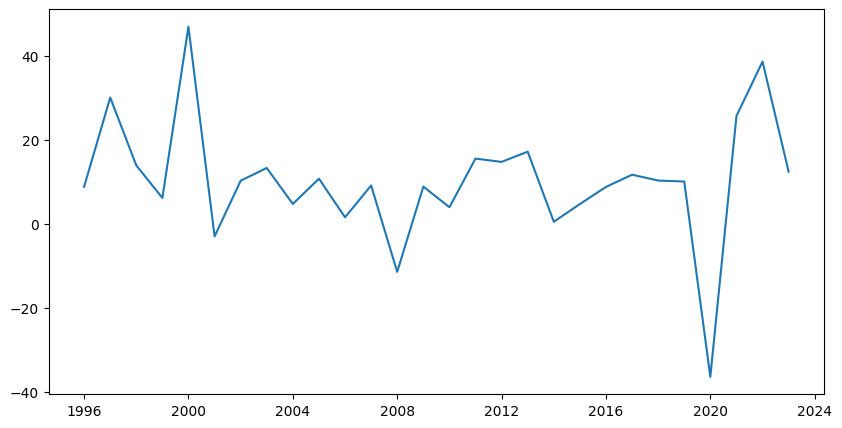

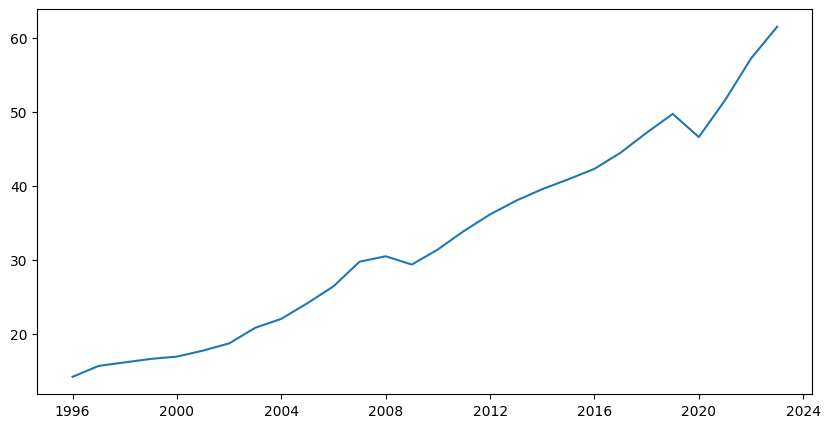

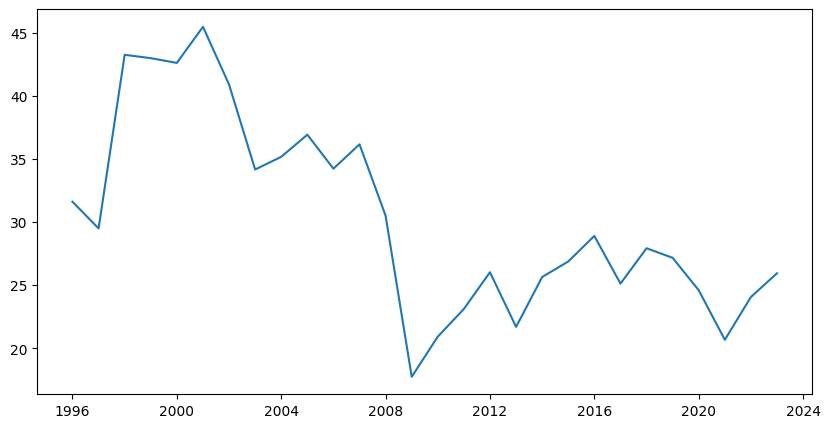

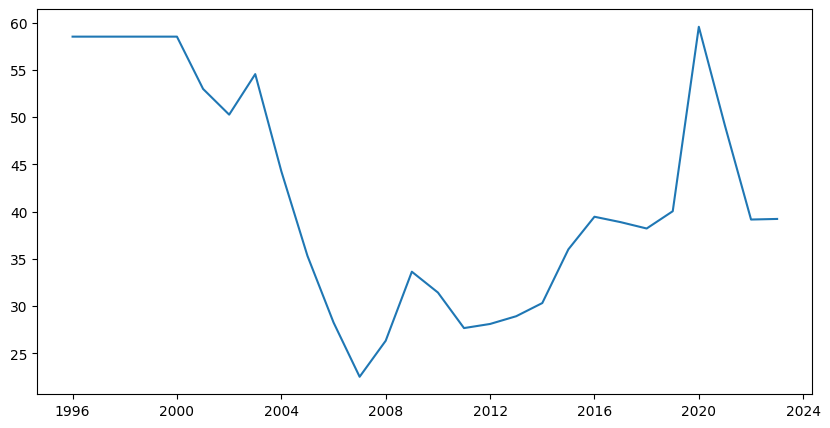

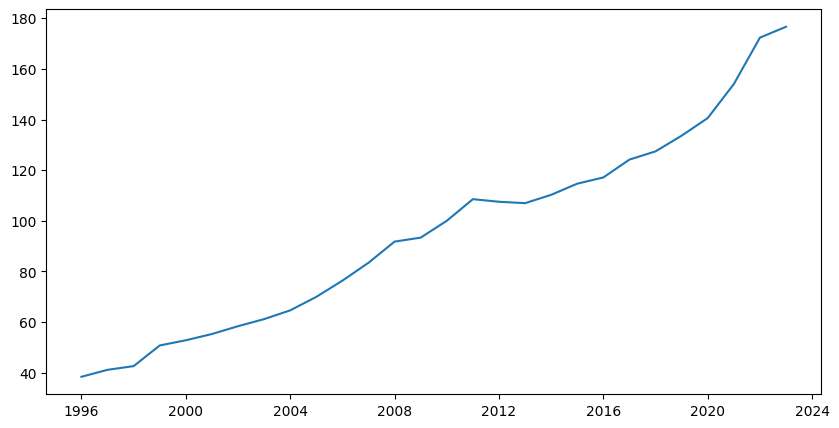

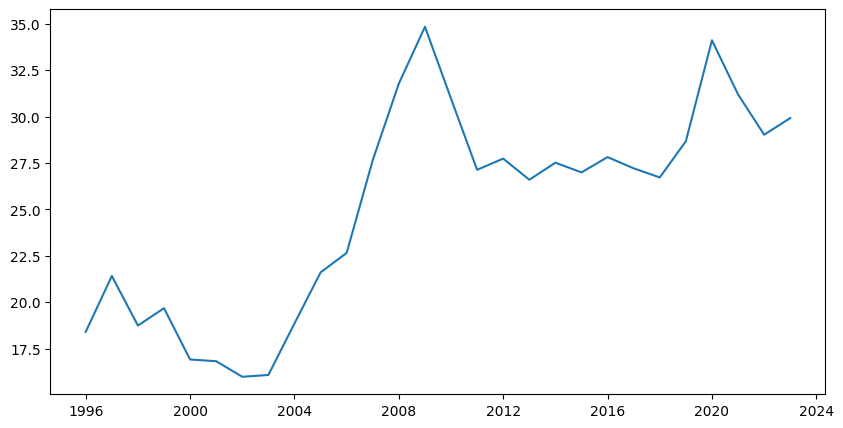

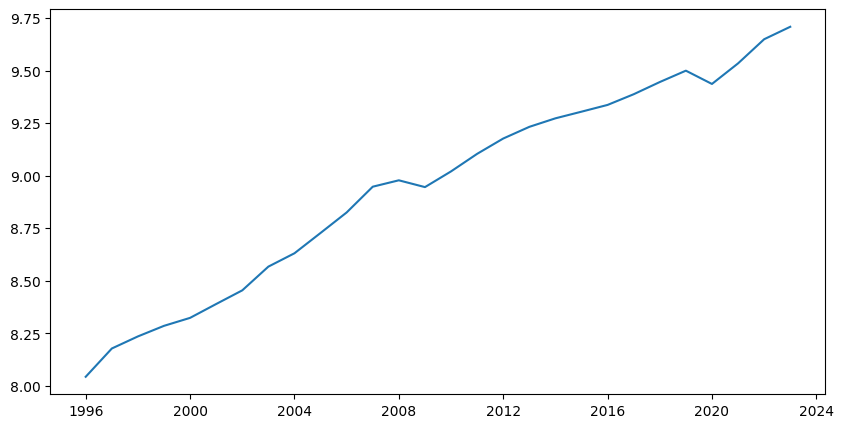

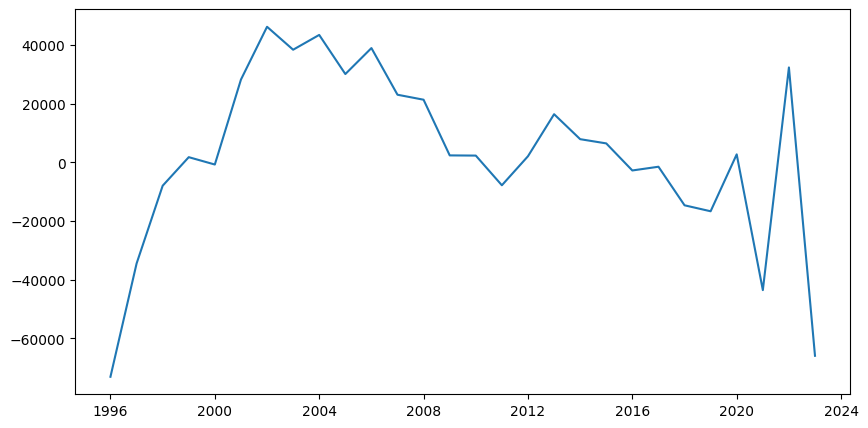

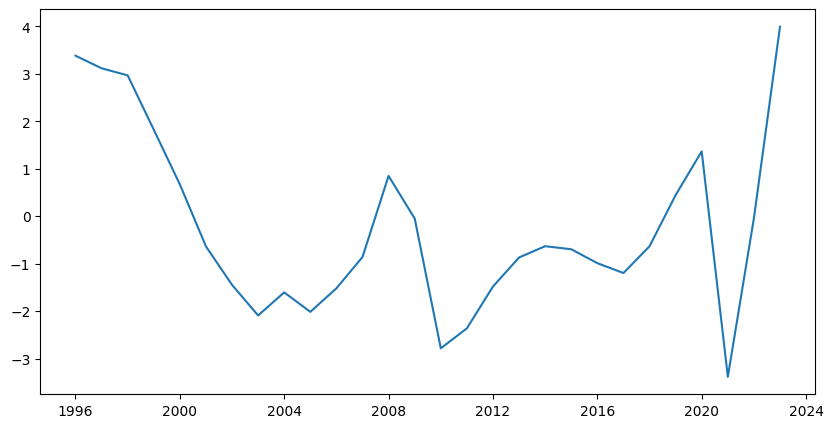

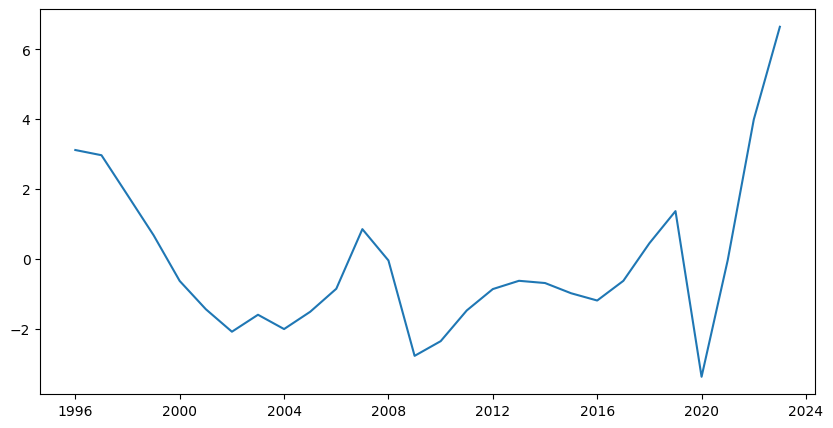

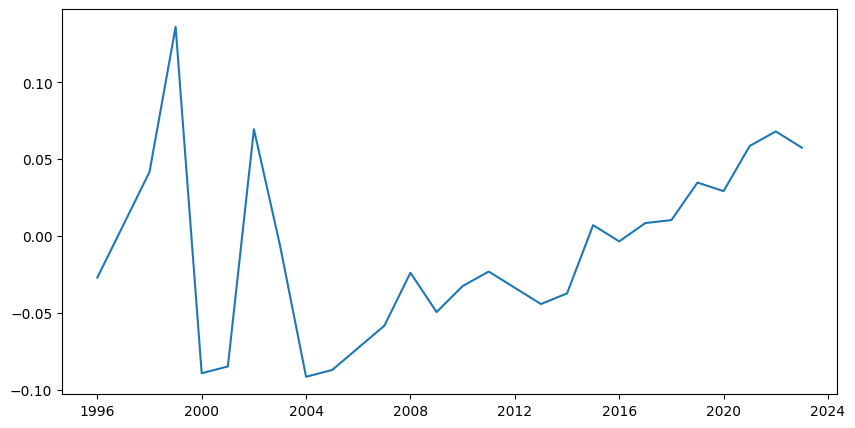

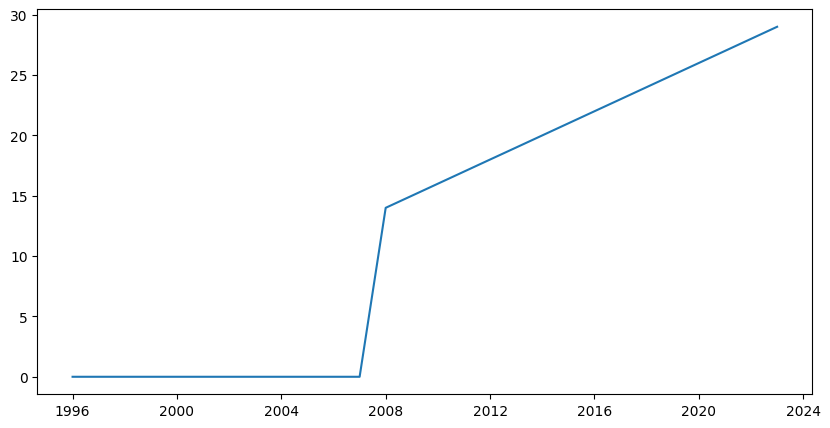

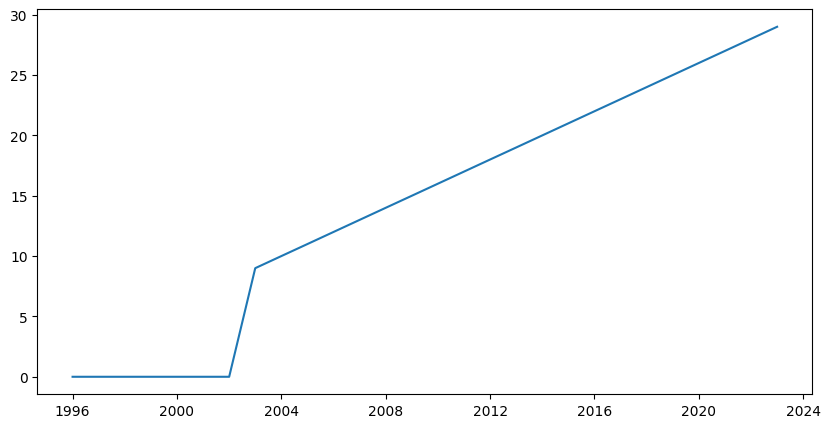

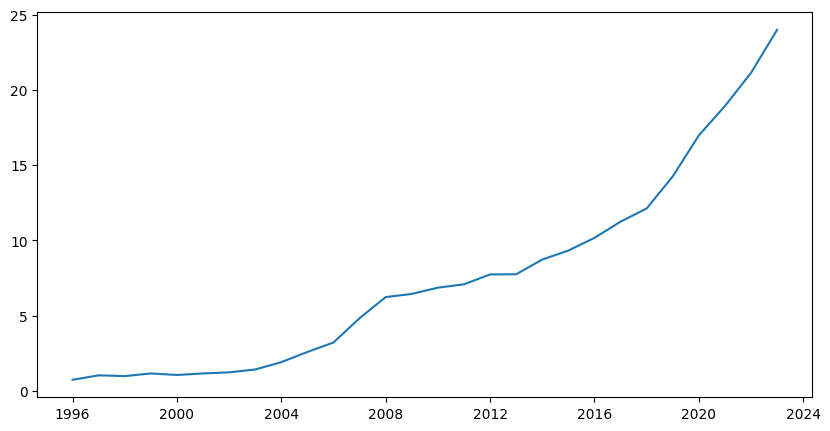

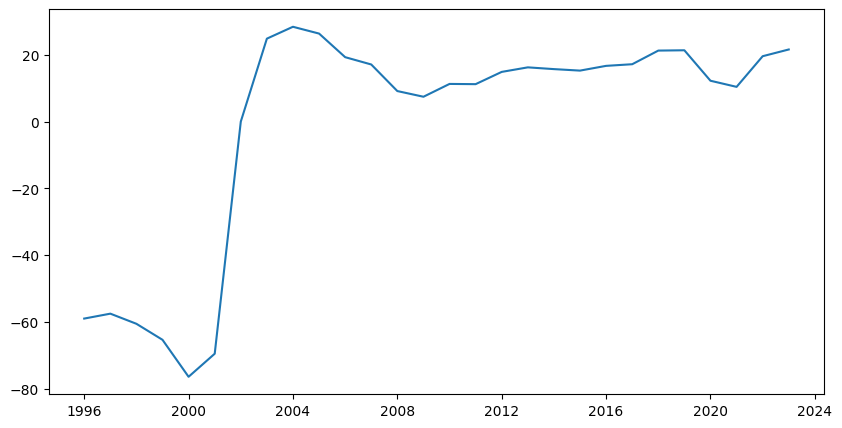

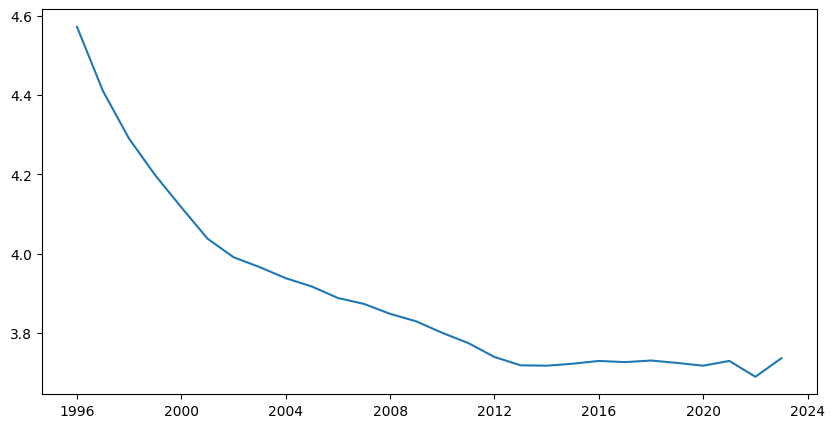

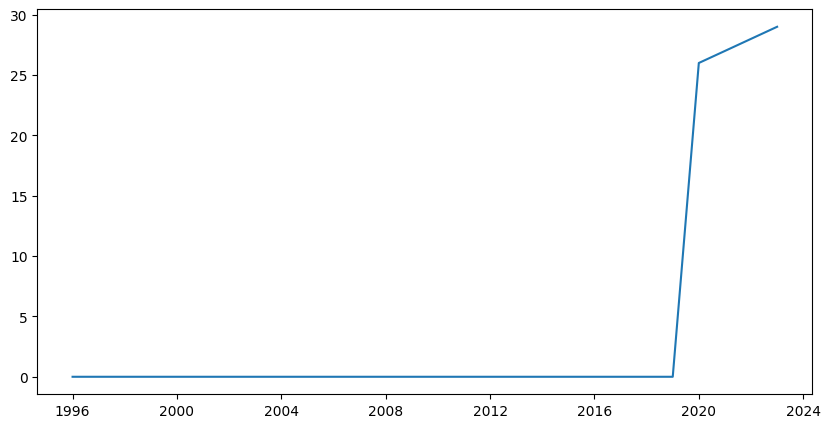

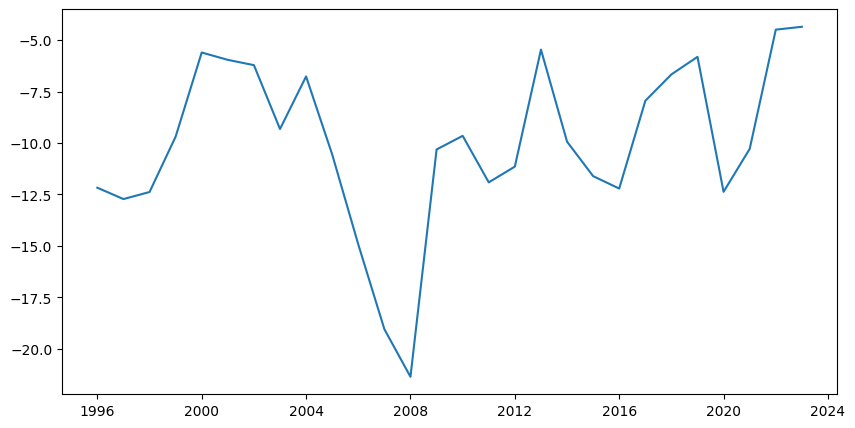

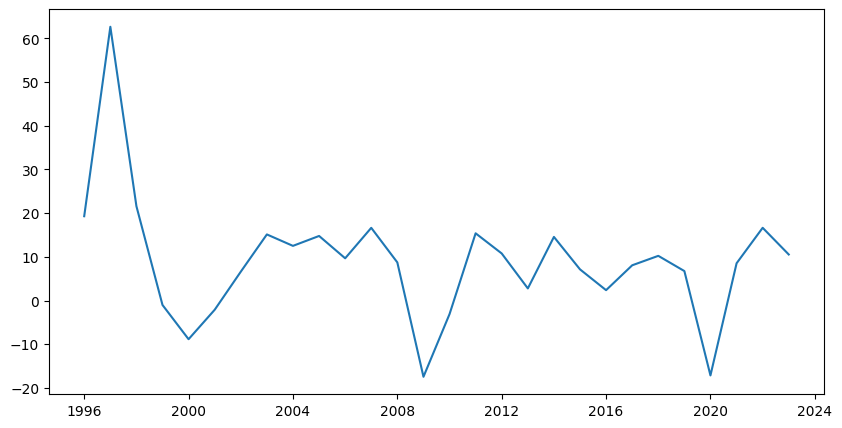

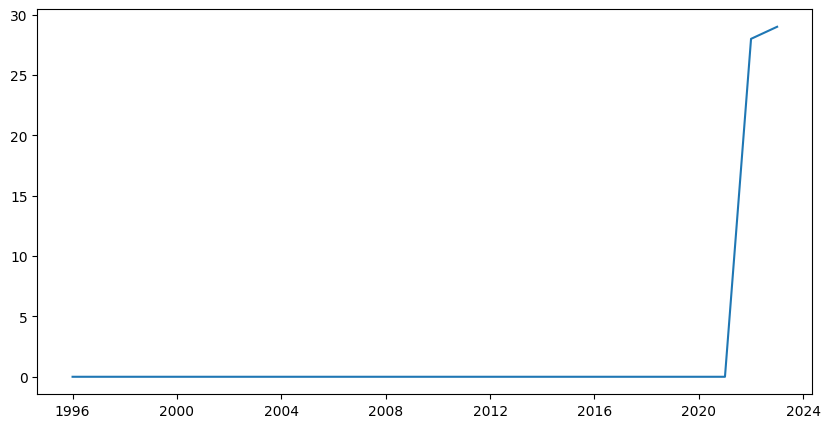

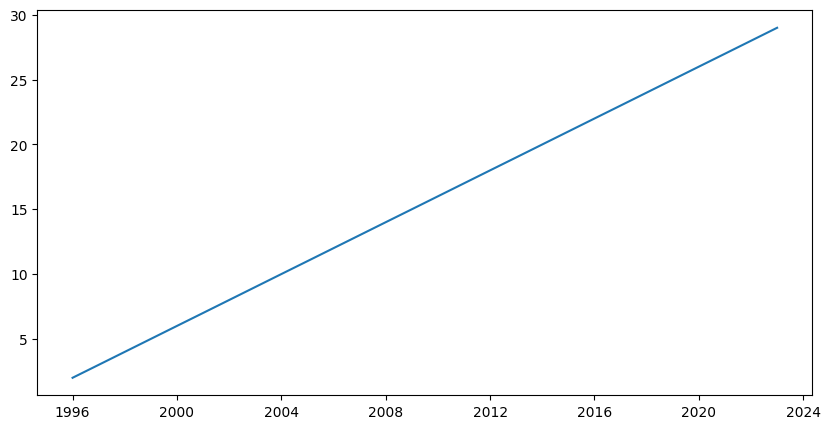

In [17]:
################################# Plot of other variables for slides ##########################

from statsmodels.sandbox.regression.gmm import IV2SLS

rawdata=rawdata.head(30)
# Identify variables that are in rawdata but not in data
extra_vars = set(rawdata.columns) - set(data.columns)

# Plot these extra variables
for column in extra_vars:
    plt.figure(figsize=(10, 5))
    plt.plot(rawdata.index, rawdata[column], label=column)
    plt.show()



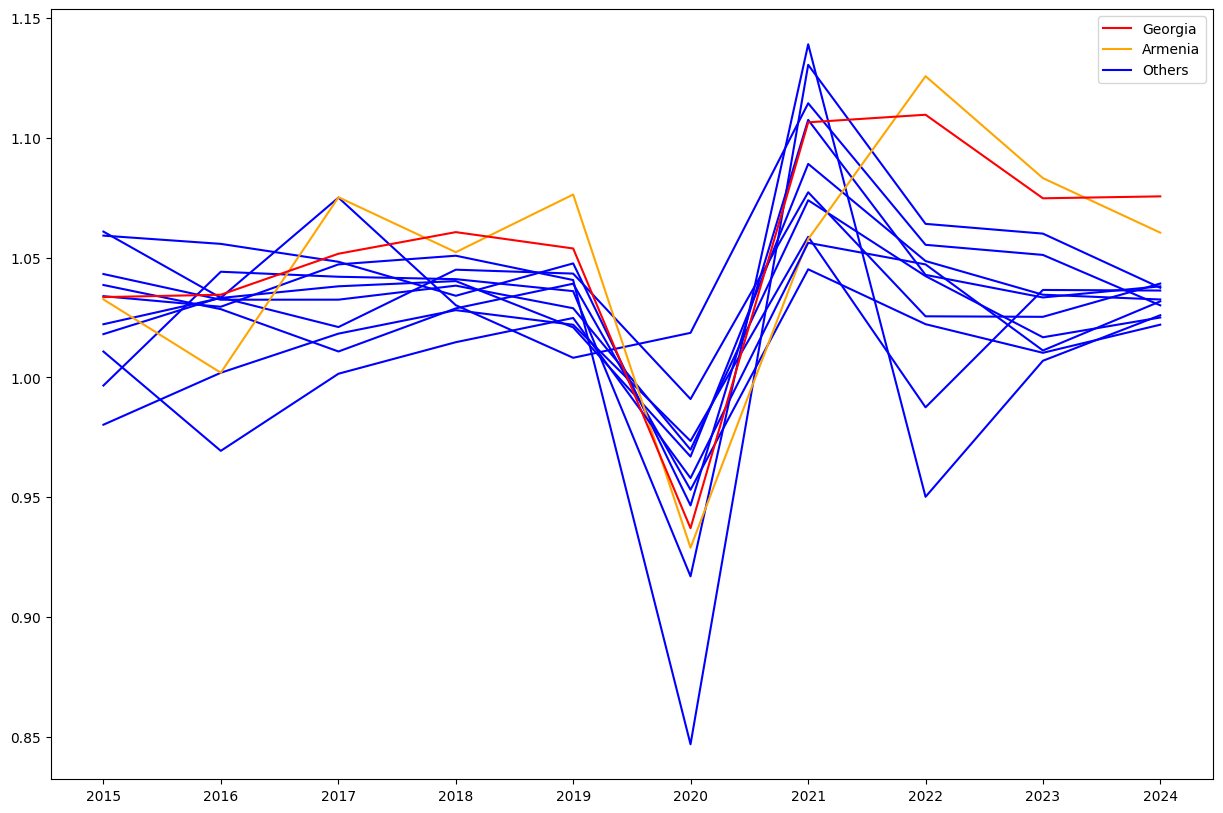

In [18]:
#################################### Control Group #######################################

# Plot the data of different countries over time
control_group_data = pd.read_excel("Control Group.xlsx", parse_dates=[0], index_col=0)

# Plot all countries on the same graph
plt.figure(figsize=(15, 10))
for country in control_group_data.columns:
    if country == 'Georgia':
        plt.plot(control_group_data.index, control_group_data[country], label=country, color='red')
    elif country == 'Armenia':
        plt.plot(control_group_data.index, control_group_data[country], label=country, color='orange')
    else:
        plt.plot(control_group_data.index, control_group_data[country], label=country, color='blue')


# Update legend to only mention Georgia, Armenia, and "others"

handles, labels = plt.gca().get_legend_handles_labels()
new_labels = ['Georgia', 'Armenia', 'Others']
new_handles = [handles[labels.index('Georgia')], handles[labels.index('Armenia')], handles[0]]
plt.legend(new_handles, new_labels)
plt.show()

In [19]:
################################### remittances ####################################

# Define the dependent variable
y_remit = rawdata['realgdppc']

# Define the independent variables
X_remit = rawdata[['remittances', 'realgdppc_lag', 'Break_2003', 'Break_2008', 'Break_2020', 'Break_2022', 'trend']]

# Create interaction terms
rawdata['trend_Break_2022'] = rawdata['trend'] * rawdata['Break_2022']
rawdata['remit_Break_2022'] = rawdata['remittances'] * rawdata['Break_2022']

# Add interaction terms to the independent variables
X_remit['trend_Break_2022'] = rawdata['trend_Break_2022']
X_remit['remit_Break_2022'] = rawdata['remit_Break_2022']

# Drop rows with NaN values (due to lagging)
X_remit = X_remit.dropna()
y_remit = y_remit.loc[X_remit.index]

# Add a constant to the independent variables
X_remit = sm.add_constant(X_remit)

# Fit the OLS model with robust covariance type
model_remit = sm.OLS(y_remit, X_remit).fit()

# Print the summary of the regression
print(model_remit.summary())

                            OLS Regression Results                            
Dep. Variable:              realgdppc   R-squared:                       0.997
Model:                            OLS   Adj. R-squared:                  0.996
Method:                 Least Squares   F-statistic:                     849.9
Date:                Sun, 15 Dec 2024   Prob (F-statistic):           1.34e-22
Time:                        16:55:25   Log-Likelihood:                -188.31
No. Observations:                  28   AIC:                             394.6
Df Residuals:                      19   BIC:                             406.6
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const             1092.6653    257.724  

/tmp/ipykernel_2655/3463188498.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_remit['trend_Break_2022'] = rawdata['trend_Break_2022']
/tmp/ipykernel_2655/3463188498.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_remit['remit_Break_2022'] = rawdata['remit_Break_2022']


In [20]:
################################### remittances2 ####################################

# Define the dependent variable
y_remit2 = rawdata['realgdppc']

# Define the independent variables
X_remit2 = rawdata[['remittances', 'Break_2003', 'Break_2008', 'Break_2020', 'Break_2022', 'trend']]


# Drop rows with NaN values (due to lagging)
X_remit2 = X_remit2.dropna()
y_remit2 = y_remit2.loc[X_remit2.index]

# Add a constant to the independent variables
X_remit2 = sm.add_constant(X_remit2)

# Add interaction terms to the independent variables
X_remit2['trend_Break_2022'] = rawdata['trend_Break_2022']
X_remit2['remit_Break_2022'] = rawdata['remit_Break_2022']

# Fit the OLS model with robust covariance type
model_remit2 = sm.OLS(y_remit2, X_remit2).fit()

# Print the summary of the regression
print(model_remit2.summary())

                            OLS Regression Results                            
Dep. Variable:              realgdppc   R-squared:                       0.996
Model:                            OLS   Adj. R-squared:                  0.994
Method:                 Least Squares   F-statistic:                     638.6
Date:                Sun, 15 Dec 2024   Prob (F-statistic):           4.32e-22
Time:                        16:55:25   Log-Likelihood:                -194.88
No. Observations:                  28   AIC:                             405.8
Df Residuals:                      20   BIC:                             416.4
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const             1815.9506    176.064  

In [21]:
##################################### GPT Code ##################################


# If you want an interaction term between the 2022 break and remittances, for example:
data['2022remit'] = data['Break_2022'] * data['remittances']

# Set up the regression:
# Dependent variable: GDP growth
# Independent variables: emigration, remittances, plus the break dummies and interactions
XGPT = data[['migr', 'remitgr', 'Break_2003', 'Break_2008', 'Break_2020', 'Break_2022', '2022remit']]
XGPT = sm.add_constant(X)  # add intercept
yGPT = data['gdpgr']

modelGPT = sm.OLS(yGPT, XGPT).fit()
print(modelGPT.summary())



                            OLS Regression Results                            
Dep. Variable:                  gdpgr   R-squared:                       0.436
Model:                            OLS   Adj. R-squared:                  0.256
Method:                 Least Squares   F-statistic:                     2.428
Date:                Sun, 15 Dec 2024   Prob (F-statistic):             0.0527
Time:                        16:55:25   Log-Likelihood:                 60.772
No. Observations:                  30   AIC:                            -105.5
Df Residuals:                      22   BIC:                            -94.33
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0430      0.027      1.566      0.1

In [22]:
#################### log gdp log remittances ################

# Generate the log of remittances
rawdata['log_remittances'] = np.log(rawdata['remittances'])

# Define the dependent variable
y_log_gdp = rawdata['log_realgdp']

# Define the independent variables
X_log_gdp = rawdata[['log_remittances', 'Break_2003', 'Break_2008', 'Break_2020', 'Break_2022','trend']]

# Create interaction term between structural break of 2022 and remittances
rawdata['Break_2022_log_remittances'] = rawdata['Break_2022'] * rawdata['log_remittances']

# Add the interaction term to the independent variables
X_log_gdp['Break_2022_log_remittances'] = rawdata['Break_2022_log_remittances']

# Drop rows with NaN values (due to lagging)
X_log_gdp = X_log_gdp.dropna()
y_log_gdp = y_log_gdp.loc[X_log_gdp.index]

# Add a constant to the independent variables
X_log_gdp = sm.add_constant(X_log_gdp)

# Fit the OLS model with robust covariance type
model_log_gdp = sm.OLS(y_log_gdp, X_log_gdp).fit()

# Print the summary of the regression
print(model_log_gdp.summary())

                            OLS Regression Results                            
Dep. Variable:            log_realgdp   R-squared:                       0.996
Model:                            OLS   Adj. R-squared:                  0.995
Method:                 Least Squares   F-statistic:                     627.7
Date:                Sun, 15 Dec 2024   Prob (F-statistic):           3.02e-19
Time:                        16:55:25   Log-Likelihood:                 57.813
No. Observations:                  25   AIC:                            -99.63
Df Residuals:                      17   BIC:                            -89.87
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const               

/home/codespace/.local/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/tmp/ipykernel_2655/614169417.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_log_gdp['Break_2022_log_remittances'] = rawdata['Break_2022_log_remittances']


In [23]:
###################################### new breaks. This also looks nice#############################

# Define the dummy variables
rawdata['augwar'] = ((rawdata.index.year == 2008) | (rawdata.index.year == 2009)).astype(int)
rawdata['covid'] = ((rawdata.index.year == 2020) | (rawdata.index.year == 2021)).astype(int)

data['augwar'] = ((data.index.year == 2008) | (data.index.year == 2009)).astype(int)
data['covid'] = ((data.index.year == 2020) | (data.index.year == 2021)).astype(int)

# Define the dependent variable
y_new = rawdata['log_realgdppc']

# Define the independent variables
X_new = rawdata[['log_realgdp_lag', 'augwar', 'covid', 'Break_2022',  'log_remittances','Break_2022_log_remittances']]

# Drop rows with NaN values (due to lagging)
X_new = X_new.dropna()
y_new = y_new.loc[X_new.index]

# Add a constant to the independent variables
X_new = sm.add_constant(X_new)

# Fit the OLS model with robust covariance type
model_new = sm.OLS(y_new, X_new).fit()

# Print the summary of the regression
print(model_new.summary())

                            OLS Regression Results                            
Dep. Variable:          log_realgdppc   R-squared:                       0.997
Model:                            OLS   Adj. R-squared:                  0.995
Method:                 Least Squares   F-statistic:                     857.8
Date:                Sun, 15 Dec 2024   Prob (F-statistic):           4.15e-21
Time:                        16:55:25   Log-Likelihood:                 57.012
No. Observations:                  25   AIC:                            -100.0
Df Residuals:                      18   BIC:                            -91.49
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const               

In [54]:
####### Counterfactual ########

import pandas as pd
import numpy as np
import statsmodels.api as sm

# Step 1: Split the data
pre_2022_data = data.loc[data.index.year < 2022]
post_2022_data = data.loc[data.index.year >= 2022]

# Step 2: Fit a simple model to estimate the relationship between realgdpgr and remittances using pre-2022 data
Xcf = pre_2022_data['remittances']
ycf = pre_2022_data['gdpgr']

Xcf = sm.add_constant(Xcf)  # Add an intercept
modelcf = sm.OLS(ycf, Xcf).fit()

print(modelcf.summary())

# Step 3: Determine a counterfactual trend for remittances post-2022.
# For simplicity, let's assume a linear trend in remittances. We'll fit a linear trend on pre-2022 remittances vs. time.

trend_df = pre_2022_data.reset_index()
trend_years = trend_df.index  # Just a sequence of 0,1,2,... for the regression
trend_remitt = trend_df['remittances']

trend_X = sm.add_constant(trend_years)
trend_model = sm.OLS(trend_remitt, trend_X).fit()

# Now predict what remittances would have been after 2022 if they followed the established trend.
post_2022_years = post_2022_data.index
# Align these years with a continuation of the trend index
# The last pre-2022 year is (2021), which might have index = length_of_pre_data - 1
last_pre_index = trend_years[-1] # This gives the highest index in the pre-period
post_period_indices = np.arange(last_pre_index + 1, last_pre_index + 1 + len(post_2022_years))

post_2022_counterfactual_remitt = trend_model.predict(sm.add_constant(post_period_indices))

# Create a counterfactual scenario DataFrame
counterfactual_df = post_2022_data.copy()
counterfactual_df['remittances_cf'] = post_2022_counterfactual_remitt

# Step 4: Predict what realgdpgr would have been with these counterfactual remittances
# Use the previously fitted model (realgdpgr ~ remittances) to predict
X_cf = sm.add_constant(counterfactual_df['remittances_cf'])
counterfactual_gdp = modelcf.predict(X_cf)

counterfactual_df['realgdpgr_cf'] = counterfactual_gdp

# Step 5: Compare actual vs. counterfactual realgdpgr
comparison = pd.DataFrame({
    'actual_realgdpgr': post_2022_data['gdpgr'],
    'actual_remittances': post_2022_data['remittances'],
    'counterfactual_remittances': counterfactual_df['remittances_cf'],
    'counterfactual_realgdpgr': counterfactual_df['realgdpgr_cf']
}, index=post_2022_data.index)

print(comparison)



# Interpretation:
# - The 'counterfactual_realgdpgr' column shows what the model predicts realgdpgr would have been if remittances had continued on their pre-2022 trend.
# - Comparing 'actual_realgdpgr' to 'counterfactual_realgdpgr' gives an estimate of how much GDP growth deviated from what might have been expected in the absence of a post-2022 shock to remittances.

                            OLS Regression Results                            
Dep. Variable:                  gdpgr   R-squared:                       0.006
Model:                            OLS   Adj. R-squared:                 -0.032
Method:                 Least Squares   F-statistic:                    0.1558
Date:                Sun, 15 Dec 2024   Prob (F-statistic):              0.696
Time:                        18:04:33   Log-Likelihood:                 48.766
No. Observations:                  28   AIC:                            -93.53
Df Residuals:                      26   BIC:                            -90.87
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.0563      0.013      4.473      

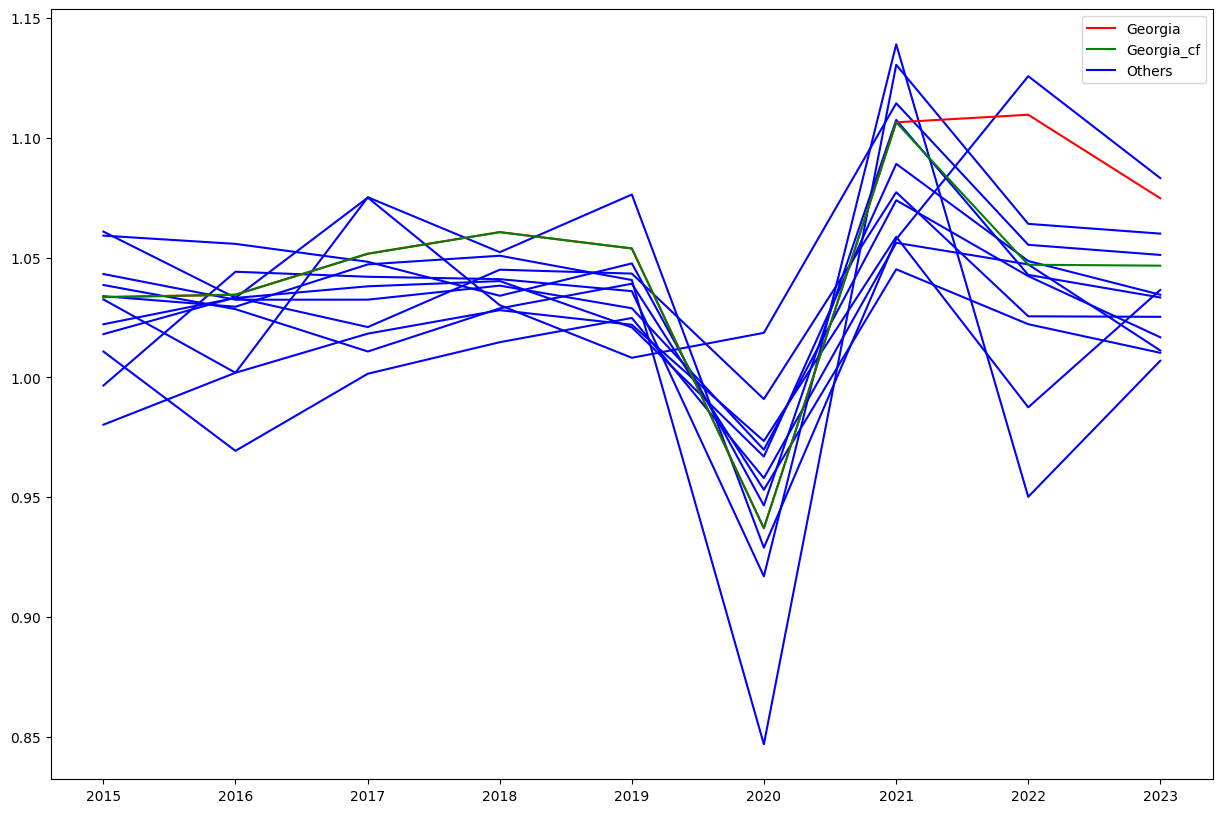

In [44]:
# Append the new column to the Control Group dataframe
control_group_data['Georgia_cf'] = control_group_data['Georgia']

# Replace the values in 2022 and 2023 with the counterfactuals
control_group_data.loc['2022-01-01', 'Georgia_cf'] = 1.047014
control_group_data.loc['2023-01-01', 'Georgia_cf'] = 1.046629

# Plot all countries on the same graph
plt.figure(figsize=(15, 10))
for country in control_group_data.columns:
    if country == 'Georgia':
        plt.plot(control_group_data.index, control_group_data[country], label=country, color='red')
    elif country == 'Georgia_cf':
        plt.plot(control_group_data.index, control_group_data[country], label=country, color='green')
    else:
        plt.plot(control_group_data.index, control_group_data[country], label=country, color='blue')

# Update legend to only mention Georgia, Georgia_cf, Armenia, and "others"
handles, labels = plt.gca().get_legend_handles_labels()
new_labels = ['Georgia', 'Georgia_cf', 'Others']
new_handles = [handles[labels.index('Georgia')], handles[labels.index('Georgia_cf')], handles[0]]
plt.legend(new_handles, new_labels)
plt.show()

# Remove 2024 from the plot
control_group_data = control_group_data[control_group_data.index.year != 2024]

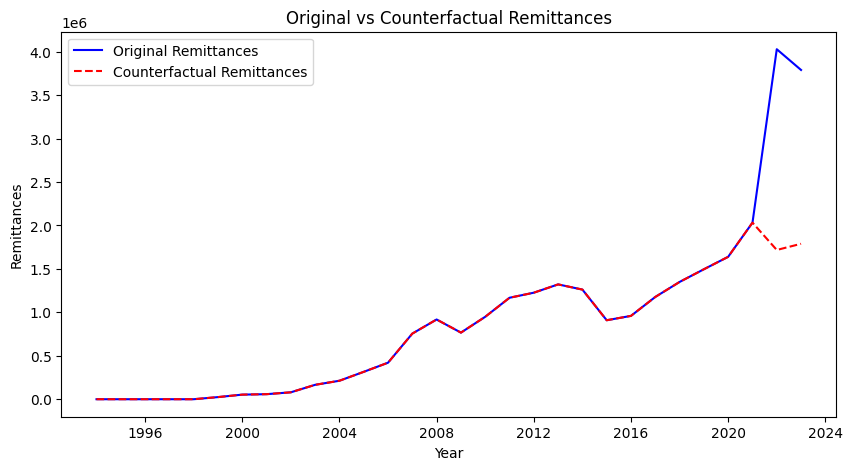

In [51]:
# Filter remittances data before 2022
remittances_pre_2022 = remittances.loc[remittances.index.year < 2022]

# Create a time index for the pre-2022 data
time_index = np.arange(len(remittances_pre_2022))

# Fit a linear trend model
trend_model = sm.OLS(remittances_pre_2022['remit'], sm.add_constant(time_index)).fit()

# Predict remittances for 2022 and 2023
future_time_index = np.array([len(remittances_pre_2022), len(remittances_pre_2022) + 1])
predicted_remittances = trend_model.predict(sm.add_constant(future_time_index))

# Create a DataFrame for counterfactual remittances
remittances_cf = remittances.copy()
remittances_cf.loc['2022-01-01', 'remit'] = predicted_remittances[0]
remittances_cf.loc['2023-01-01', 'remit'] = predicted_remittances[1]

# Plot original and counterfactual remittances
plt.figure(figsize=(10, 5))
plt.plot(remittances.index, remittances['remit'], label='Original Remittances', color='blue')
plt.plot(remittances_cf.index, remittances_cf['remit'], label='Counterfactual Remittances', color='red', linestyle='--')
plt.title('Original vs Counterfactual Remittances')
plt.xlabel('Year')
plt.ylabel('Remittances')
plt.legend()
plt.show()